In [1]:
from __future__ import print_function
import sys
sys.path.insert(0, '..')

import datetime

import pandas as pd
#from pathlib import Path
import torch
from torch import nn
import torch.optim as optim
from torch.optim import Adam

from torch.utils.data import random_split
from sound_dataset import SoundDS

from early_stopping import EarlyStopping

import conv_vae
import numpy as np

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200


import librosa
import soundfile as sf

from sound_utility import AudioUtil




In [2]:
"""
https://zenodo.org/records/3685367
<FAMILY>/<INSTRUMENT>/ordinario/<INSTR>-ord-<PITCH>-<DYN>-<INSTANCE>-<MISC>.wav

Intensity Dynamics:
Forte: f, loud
Piano: p, soft
Mezzo-forte: mf, medium loud
Mezzo-piano: mp, medium soft
Fortissimo: ff, very loud
Pianissimo: pp, very soft
Crescendo: Gradually increasing in volume
Decrescendo: Gradually decreasing in volume

"""
#dataset = pd.read_csv('./../accordion345.csv')
#dataset = pd.read_csv('./../Violin.csv')
dataset = pd.read_csv('./../Strings.csv')
#dataset = pd.read_csv('./../TinySOL_metadata_updated.csv')

dataset['Full_Path'] = './../TinySOL/' + dataset['Path'].astype(str)
data = dataset[['Full_Path','Instance ID']]
data.head()


Full_Path  Instance ID
0  ./../TinySOL/Strings/Violoncello/ordinario/Vc-...            2
1  ./../TinySOL/Strings/Violoncello/ordinario/Vc-...            3
2  ./../TinySOL/Strings/Violoncello/ordinario/Vc-...            1
3  ./../TinySOL/Strings/Violoncello/ordinario/Vc-...            2
4  ./../TinySOL/Strings/Violoncello/ordinario/Vc-...            3

In [3]:
dataset['Octave'].value_counts()

4    168
5    150
3    137
Name: Octave, dtype: int64

In [4]:
#sr=44100, n_fft=2048, hop_length=512
myds = SoundDS(data, './',
               duration=1,
               sr=44100,
               #n_fft=2048,
               n_fft=8192,
               hop_len=512,
               label='Instance ID',
               cutoff=128,
               highpass=True
               )

#batch_size = 32
batch_size = 1


# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False)

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available:
    device = torch.device("cuda")    
else:
    device = torch.device("cpu")

x = torch.ones(1, device=device)

print (x)




tensor([1.], device='mps:0')


In [5]:
def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets.to(device)

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  print(spec.shape)
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def stft_for_reconstruction(x, fft_size, hopsamp):
    window = np.hanning(fft_size)
    fft_size = int(fft_size)
    hopsamp = int(hopsamp)
    return np.array([np.fft.rfft(window*x[i:i+fft_size])
                     for i in range(0, len(x)-fft_size, hopsamp)])


def istft_for_reconstruction(X, fft_size, hopsamp):
    fft_size = int(fft_size)
    hopsamp = int(hopsamp)
    window = np.hanning(fft_size)
    time_slices = X.shape[0]
    len_samples = int(time_slices*hopsamp + fft_size)
    x = np.zeros(len_samples)
    for n,i in enumerate(range(0, len(x)-fft_size, hopsamp)):
        x[i:i+fft_size] += window*np.real(np.fft.irfft(X[n]))
    return x
def reconstruct_signal_griffin_lim(magnitude_spectrogram, fft_size, hopsamp, iterations):
    time_slices = magnitude_spectrogram.shape[0]
    len_samples = int(time_slices*hopsamp + fft_size)
    # Initialize the reconstructed signal to noise.
    x_reconstruct = np.random.randn(len_samples)
    n = iterations # number of iterations of Griffin-Lim algorithm.
    rmse = []
    while n > 0:
        n -= 1
        reconstruction_spectrogram = stft_for_reconstruction(x_reconstruct, fft_size, hopsamp)
        reconstruction_angle = np.angle(reconstruction_spectrogram)
        # Discard magnitude part of the reconstruction and use the supplied magnitude spectrogram instead.
        proposal_spectrogram = magnitude_spectrogram*np.exp(1.0j*reconstruction_angle)
        prev_x = x_reconstruct
        x_reconstruct = istft_for_reconstruction(proposal_spectrogram, fft_size, hopsamp)
        diff = np.sqrt(sum((x_reconstruct - prev_x)**2)/x_reconstruct.size)
        rmse.append(diff)
    return x_reconstruct, rmse

364
torch.Size([1, 4097, 87])


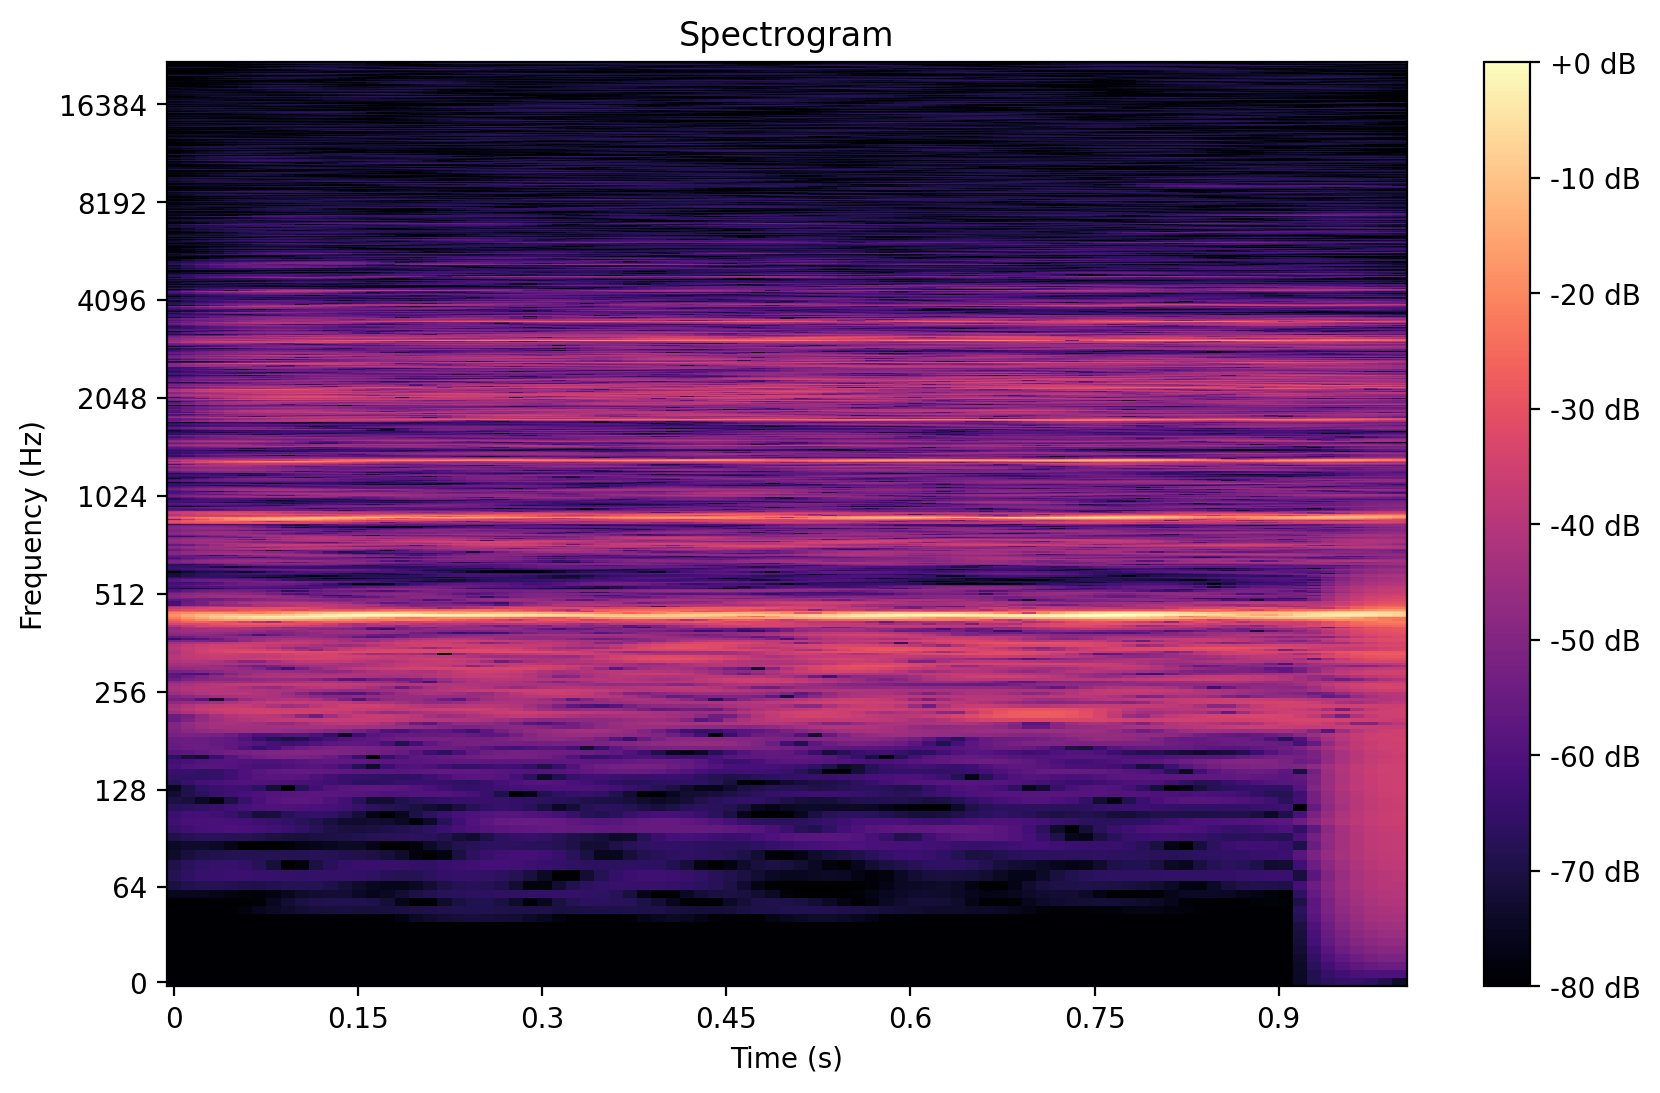

In [6]:
print(len(train_dl))
for batch_idx, (data,label) in enumerate(train_dl):

    print(data.shape)
    AudioUtil.plot_spectrogram(data[0])
    break    
#    print(label)
#    label = one_hot(label, 4)
#    print(label[0])



In [7]:
#(128x215 and 430x128)
#new (101x2 and 1103x128)

# Config for VAE xdim=413, hiddendim=1025, latent_dim=20, lr=0.00005, epochs=30, batch_size=1

#1025, 259
#x_dim = 1025*259 # number of input features for 3 seconds -> 265475
#x_dim = 1025*87
x_dim = 4097* 87
hidden_dim = 400 # number of neurons in the hidden layer
latent_dim = 50 # number of features tu learn
class_size = 4

lr = 0.00005
#lr = 1e-3
epochs = 100

#encoder = model.Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
#decoder = model.Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = conv_vae.ConvVAE(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)

print(model)

ConvVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Flatten()
    (5): Linear(in_features=323031, out_features=400, bias=True)
    (6): ReLU(inplace=True)
  )
  (mu_layer): Linear(in_features=400, out_features=50, bias=True)
  (logvar_layer): Linear(in_features=400, out_features=50, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=400, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=400, out_features=323031, bias=True)
    (3): ReLU(inplace=True)
    (4): UnFlatten()
    (5): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(8, 1, kernel_size=(5, 5), stride=(1, 1))
    (8): Tanh()
  )
)


In [8]:

# The training function for early stopping runs but the 100 epochs 

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    # MSE and KLD have different scales
    # Take into account that this VAE produces a huge output
    
    #BCE = F.binary_cross_entropy(recon_x, x.view(-1, x_dim), reduction='sum')
    
    #print('recon_x:',recon_x.shape)
    #print('x.view: ',x.view(-1, x_dim).shape)

    criterion = nn.MSELoss(reduction='sum')
    loss = criterion(recon_x, x.view( -1,x_dim))
    #loss = F.mse_loss(recon_x, x.view(-1, x_dim), reduction='sum')

    #print('mse loss:',loss)
    
    #criterion = nn.L1Loss()
    #loss = criterion(recon_x, x.view(-1, x_dim))
    #loss = F.l1_loss(recon_x, x.view(-1, x_dim), reduction='mean')


    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


    #print('KLD:',KLD)

    #return BCE + KLD
    #as an experiment, use l1loss with kld (it doesnt work well)
    #return loss
    return loss + KLD

In [ ]:
adam = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

for epoch in range(50):
  for batch_idx, (spectrogram, label) in enumerate(train_dl):

    spectrogram_tensor = spectrogram.to(dtype=torch.float32)

    #print("spectrogram tensor:",spectrogram_tensor.shape)

    #label = label.to(device)
    data = spectrogram_tensor.to(device)
    
    adam.zero_grad()

    x_pred, mu, logvar = model.forward(data)

    #print('xpred shape:', x_pred.shape)

    train_loss = loss_function(x_pred[0], data, mu, logvar)
    train_loss.backward()
    adam.step()

  for batch_idx, (spectrogram, label) in enumerate(val_dl):
    spectrogram_tensor = spectrogram.to(dtype=torch.float32)
    data = spectrogram_tensor.to(device)
    x_pred, mu, logvar = model.forward(data)

    test_loss = loss_function(x_pred[0], data, mu, logvar)

  print("\n")
  print("[{}] Train Loss={} Test Loss={}".format(epoch+1, train_loss.detach().cpu().numpy(), test_loss.detach().cpu().numpy()))
  print("\n")



In [9]:

# dont use for now

# L1 works like a charm
#criterion = nn.L1Loss()

log_interval = 10

lr = 0.0001

optimizer = Adam(model.parameters(), lr=lr)


def train_es(epochs, patience = 10):

    # Writer will output to ./runs/ directory by default
    logdir = './runs/l2_kld_h100_es_ ' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    writer = SummaryWriter(logdir)

    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(1, epochs + 1):

        model.train()
        train_loss = 0

        for batch_idx, (spectrogram,label) in enumerate(train_dl):

            #scipy works with cpu when applying the highpass filter
            spectrogram_tensor = spectrogram.to(dtype=torch.float32)

            #print("spectrogram tensor:",spectrogram_tensor.shape)

            #label = label.to(device)
            data = spectrogram_tensor.to(device)
            #label = one_hot(label, class_size) # class number, not sure yet 

            optimizer.zero_grad()

            #recon_batch, mu, logvar = model(data,label[0])
            recon_batch, mu, logvar = model(data)
            
            # recon_batch is prediction, data is ground_truth        
            #criterion is for l1 or mse
            #loss = criterion(recon_batch, data.view(-1, x_dim))

            loss = loss_function(recon_batch.view(-1,x_dim), data, mu, logvar)

            loss.backward()

            train_loss += loss.item()
            writer.add_scalar('Loss/train', train_loss, epoch)
            optimizer.step()
            
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(
                    epoch, batch_idx * len(data), len(train_dl.dataset),
                    100. * batch_idx / len(train_dl), loss.item()))

        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(train_dl.dataset)))


        """if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_dl.dataset),
                    100. * batch_idx / len(train_dl),
                    loss.item() / len(data)))

        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(train_dl.dataset)))"""

        # Validation
        model.eval()
        val_loss = 0

        with torch.no_grad():

            for i, (spectrogram,labels) in enumerate(val_dl):
                float32_tensor = spectrogram.to(dtype=torch.float32)
                data = float32_tensor.to(device)
                #labels = labels.to(device)
                #labels = one_hot(labels, class_size) # 

                #recon_batch, mu, logvar = model(data,labels[0])
                recon_batch, mu, logvar = model(data)
                
                #val_loss += criterion(recon_batch, data[0]) #.item()
                val_loss += loss_function(recon_batch.view(-1,x_dim), data, mu, logvar).item()

                #val_loss = criterion(recon_batch, data.view(-1, x_dim))
                
                #spec = recon_batch.squeeze().cpu().numpy()

                #AudioUtil.plot_spectrogram(spec)

                #x_rec, rmse = reconstruct_signal_griffin_lim(mag_subset.T, 2048, 512, 30)
                #x_rec, rmse = reconstruct_signal_griffin_lim(spec.T, 2048, 512, 30)            

                #sf.write(f'./reconstructed_violin_high_pass/test_reconst_{i}.wav', x_rec, 44100)
                
                #sf.write(f'./reconstructed_accordion/test_reconst_{i}.wav', x_rec, 44100)

        #val_loss /= len(val_dl.dataset)

        # Calculate average losses
        train_loss /= len(train_dl.dataset)
        val_loss /= len(val_dl.dataset)
        
        print('====> Test set loss: {:.4f}'.format(val_loss))

        early_stopping(val_loss)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    writer.close()



In [ ]:
# regular training function
# This function doesn't incorporate early stopping
# The dataset returns each spectrogram after applying a highpass filter

log_interval = 10

lr = 0.0001

optimizer = Adam(model.parameters(), lr=lr)

# L1 works like a charm
#criterion = nn.L1Loss()

def train(epochs):
    model.train()
    train_loss = 0

    # Writer will output to ./runs/ directory by default
    #logdir = './runs/l1_short_window_ ' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    #writer = SummaryWriter(logdir)

    for epoch in range(1, epochs + 1):
        for batch_idx, (spectrogram,label) in enumerate(train_dl):

            #print('spec:',spectrogram.shape)

            #scipy works with cpu when applying the highpass filter
            spectrogram_tensor = spectrogram.to(dtype=torch.float32)
            #label = label.to(device)
            data = spectrogram_tensor.to(device)
            #label = one_hot(label, class_size) # class number, not sure yet 
            optimizer.zero_grad()

            #recon_batch, mu, logvar = model(data, label[0])
            recon_batch, mu, logvar = model(data)
            
            # recon_batch is prediction, data is ground_truth        
            #criterion is for l1 or mse
            #loss = criterion(recon_batch, data)
            
            #loss = criterion(recon_batch, data.view(-1, x_dim))
            
            loss = loss_function(recon_batch.view(-1,x_dim), data, mu, logvar)

            loss.backward()

            if torch.isnan(loss):
                print('Loss is nan')
                return

            train_loss += loss.item()
            #writer.add_scalar('Loss/train', train_loss, epoch)
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_dl.dataset),
                    100. * batch_idx / len(train_dl),
                    loss.item() / len(data)))

        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(train_dl.dataset)))

    #writer.close()


In [10]:

patience = 3
#patience = 10
#epochs = 100
epochs=100
train_es(epochs, patience)
#train(epochs)



Train Epoch: 1 [0/364 (0%)]	Loss: 48563.9570
Train Epoch: 1 [10/364 (3%)]	Loss: 21109.0508
Train Epoch: 1 [20/364 (5%)]	Loss: 1262207.8750
Train Epoch: 1 [30/364 (8%)]	Loss: 17369.8340
Train Epoch: 1 [40/364 (11%)]	Loss: 12962.2002
Train Epoch: 1 [50/364 (14%)]	Loss: 36804.1328
Train Epoch: 1 [60/364 (16%)]	Loss: 382550.1875
Train Epoch: 1 [70/364 (19%)]	Loss: 5866.5854
Train Epoch: 1 [80/364 (22%)]	Loss: 328824.0938
Train Epoch: 1 [90/364 (25%)]	Loss: 657907.8750
Train Epoch: 1 [100/364 (27%)]	Loss: 15230.0244
Train Epoch: 1 [110/364 (30%)]	Loss: 119048.5859
Train Epoch: 1 [120/364 (33%)]	Loss: 71641.8828
Train Epoch: 1 [130/364 (36%)]	Loss: 8285.4473
Train Epoch: 1 [140/364 (38%)]	Loss: 6083.4272
Train Epoch: 1 [150/364 (41%)]	Loss: 28247.0977
Train Epoch: 1 [160/364 (44%)]	Loss: 43407.2109
Train Epoch: 1 [170/364 (47%)]	Loss: 54468.2539
Train Epoch: 1 [180/364 (49%)]	Loss: 1397747.7500
Train Epoch: 1 [190/364 (52%)]	Loss: 1377653.8750
Train Epoch: 1 [200/364 (55%)]	Loss: 26670.0000


In [16]:
# use the test method to reconstruct the spectrograms using the validation set

def test(epoch):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for i, spectrogram in enumerate(val_dl):
            float32_tensor = spectrogram.to(dtype=torch.float32)
            data = float32_tensor.to(device)

            recon_batch, mu, logvar = model(data)
            
            test_loss += loss_function(recon_batch.view(-1,x_dim), data, mu, logvar)
            spec = recon_batch.squeeze().cpu().numpy()

            AudioUtil.plot_spectrogram(spec)

            #x_rec, rmse = reconstruct_signal_griffin_lim(mag_subset.T, 2048, 512, 30)
            #x_rec, rmse = reconstruct_signal_griffin_lim(spec.T, 2048, 512, 30)            

            x_rec, rmse = reconstruct_signal_griffin_lim(spec.T, 8192, 512, 30)            
            #x_rec, rmse = reconstruct_signal_griffin_lim(spec.T, 8192, 512, 30)            


            sf.write(f'./reconstructed/test_reconst_{i}.wav', x_rec, 44100)
            #sf.write(f'./reconstructed_string_accordion_val/test_reconst_{i}.wav', x_rec, 44100)

    test_loss /= len(val_dl.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


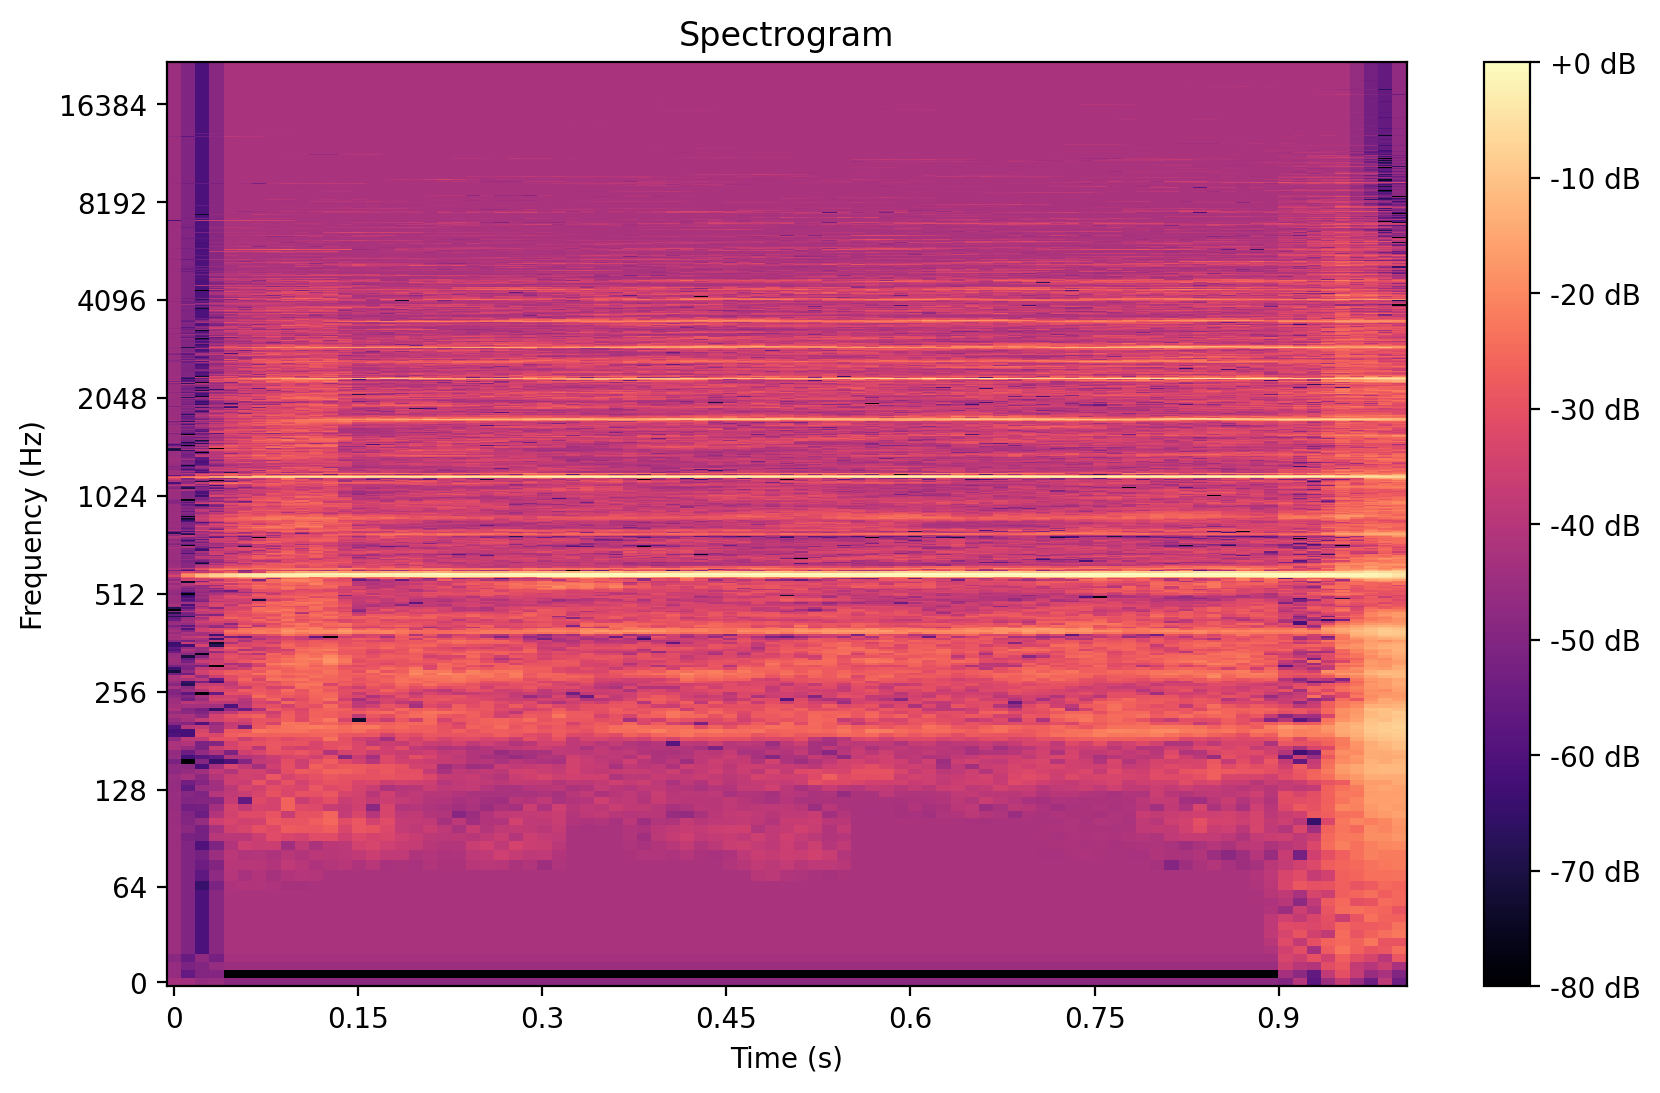

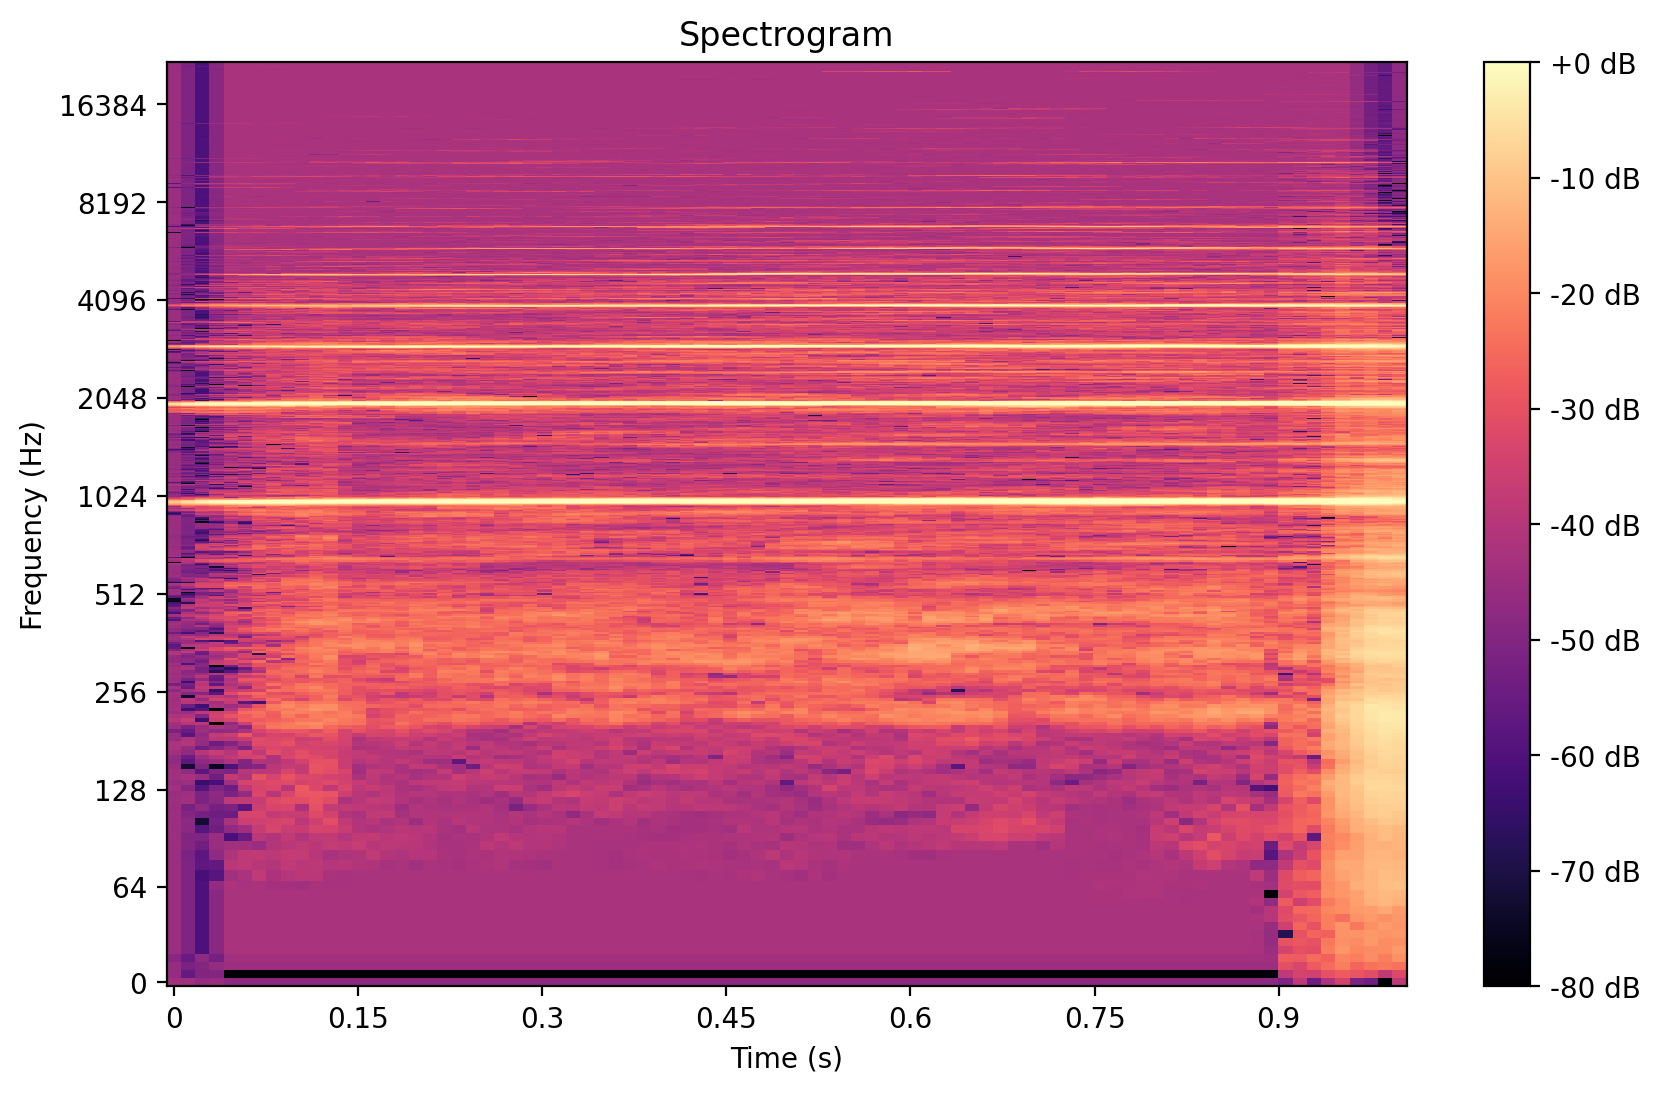

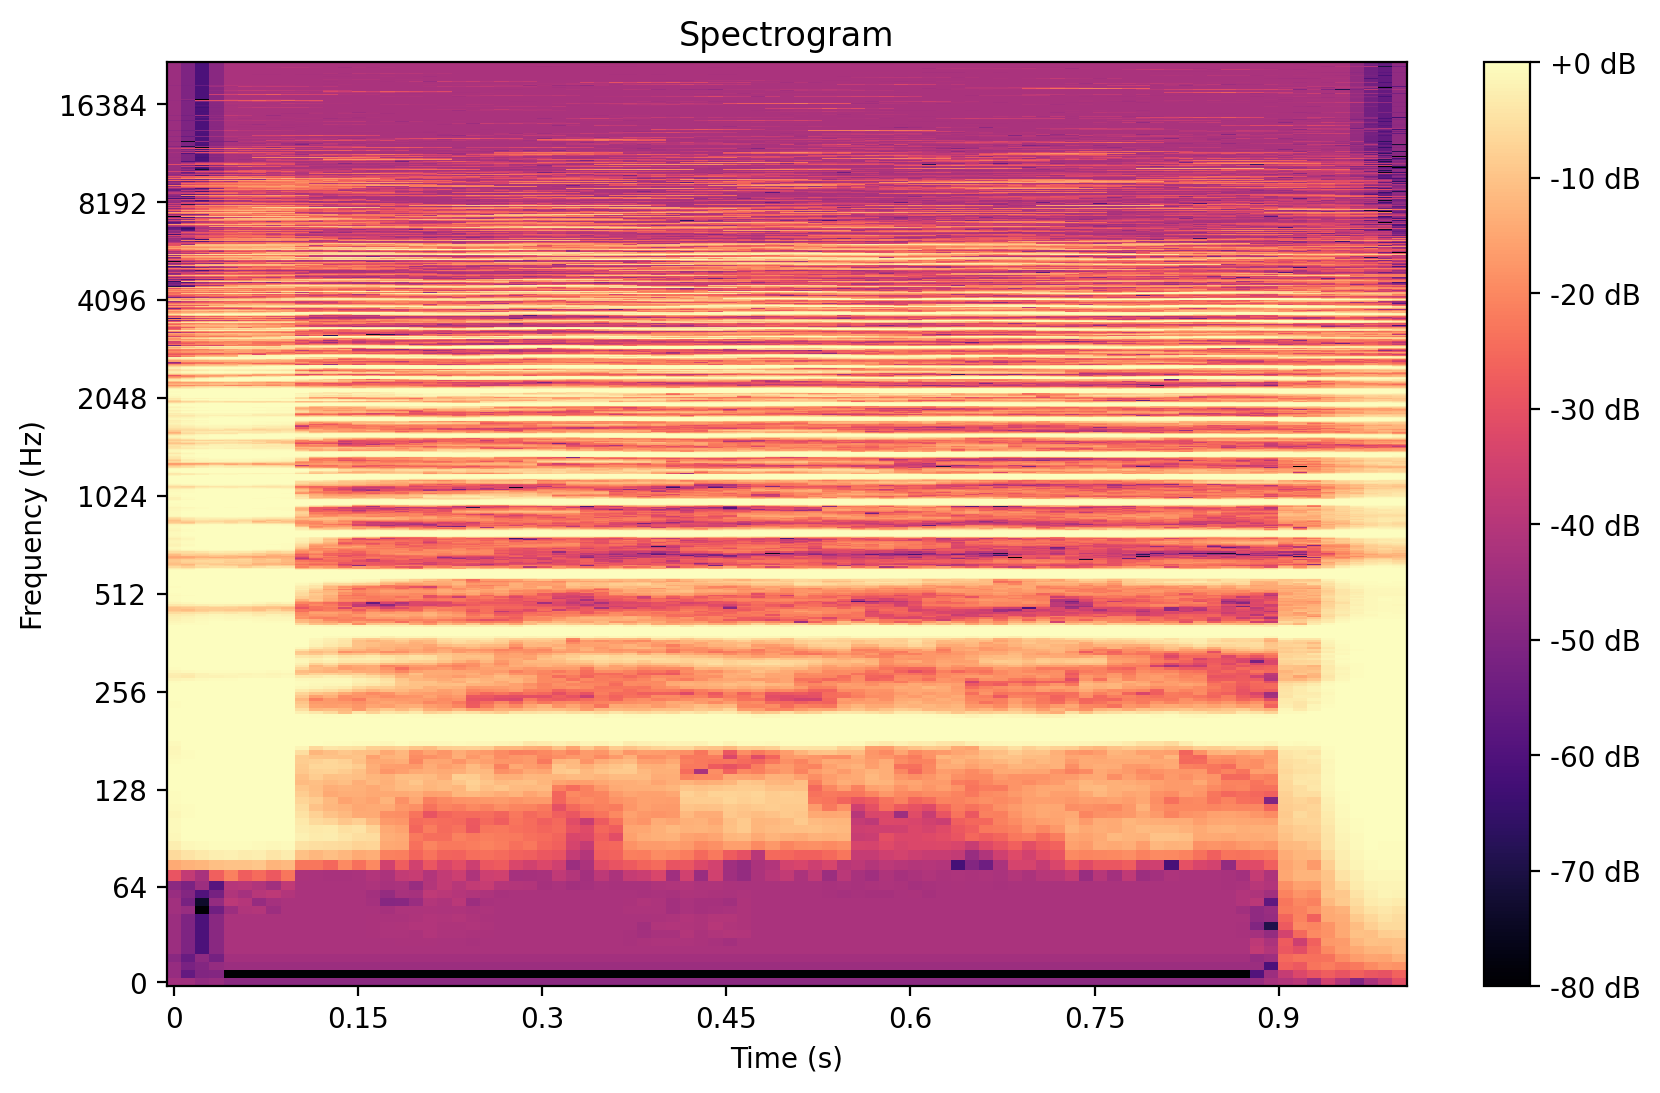

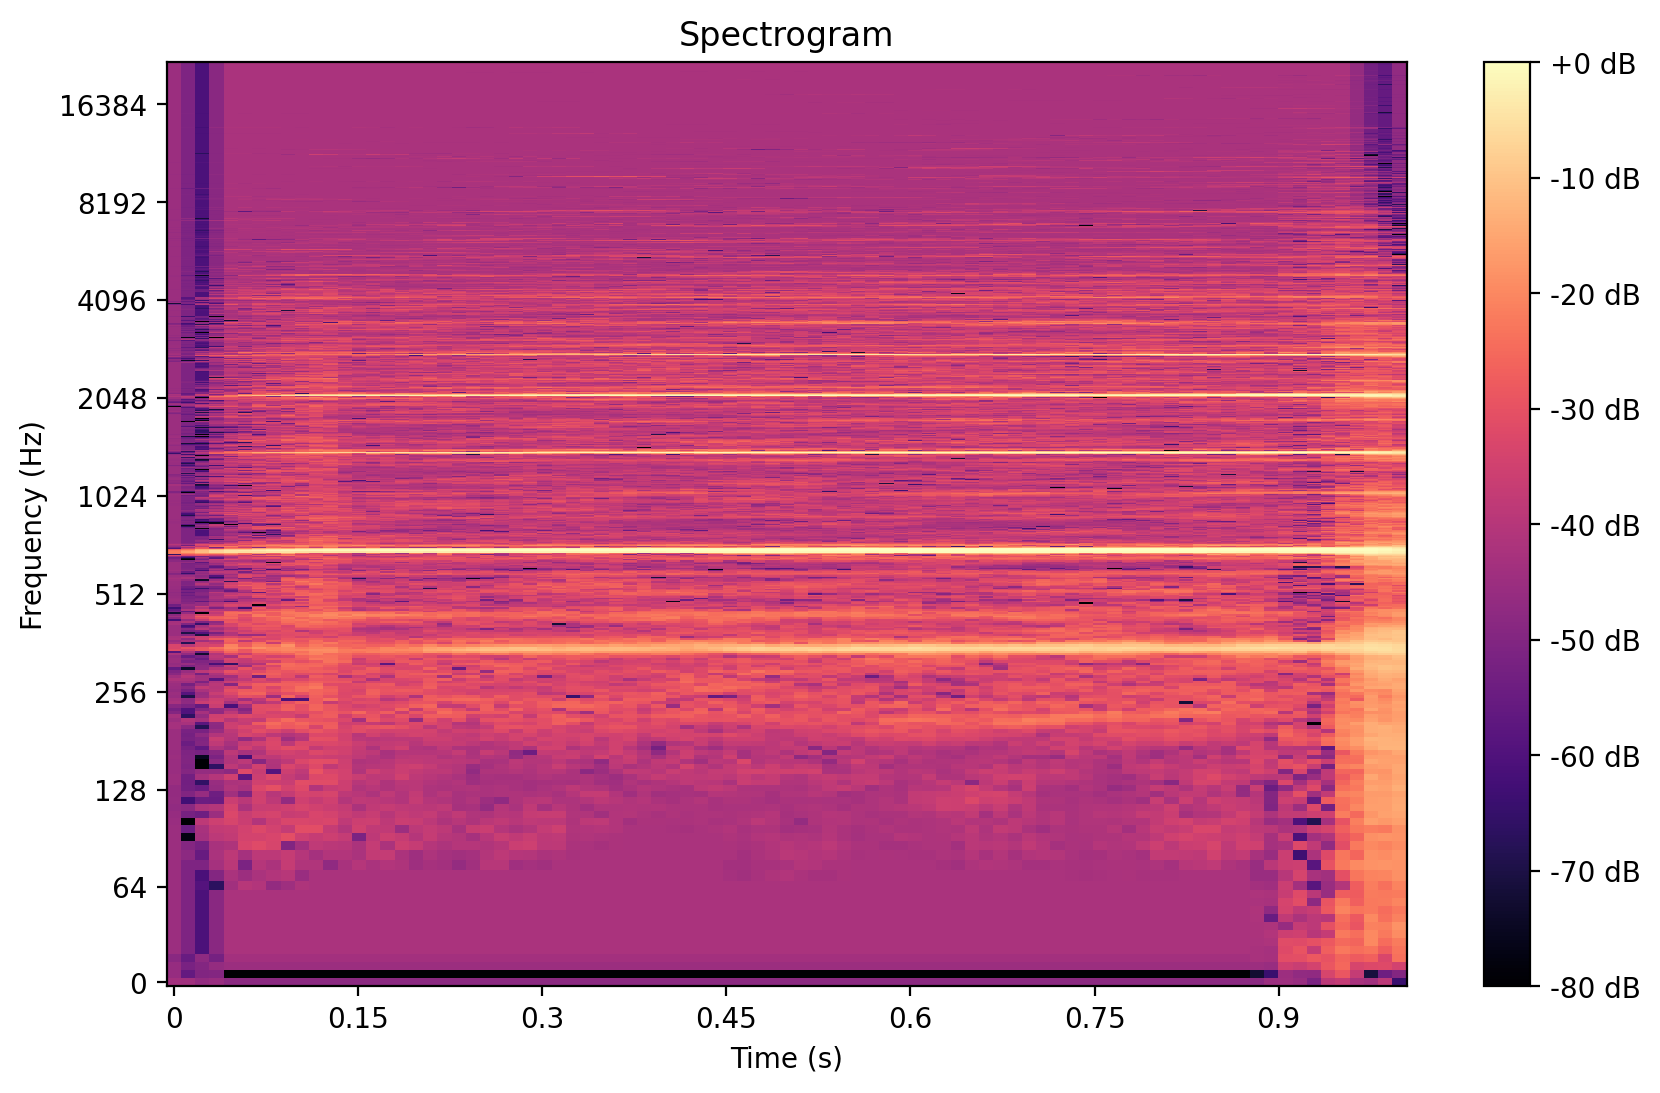

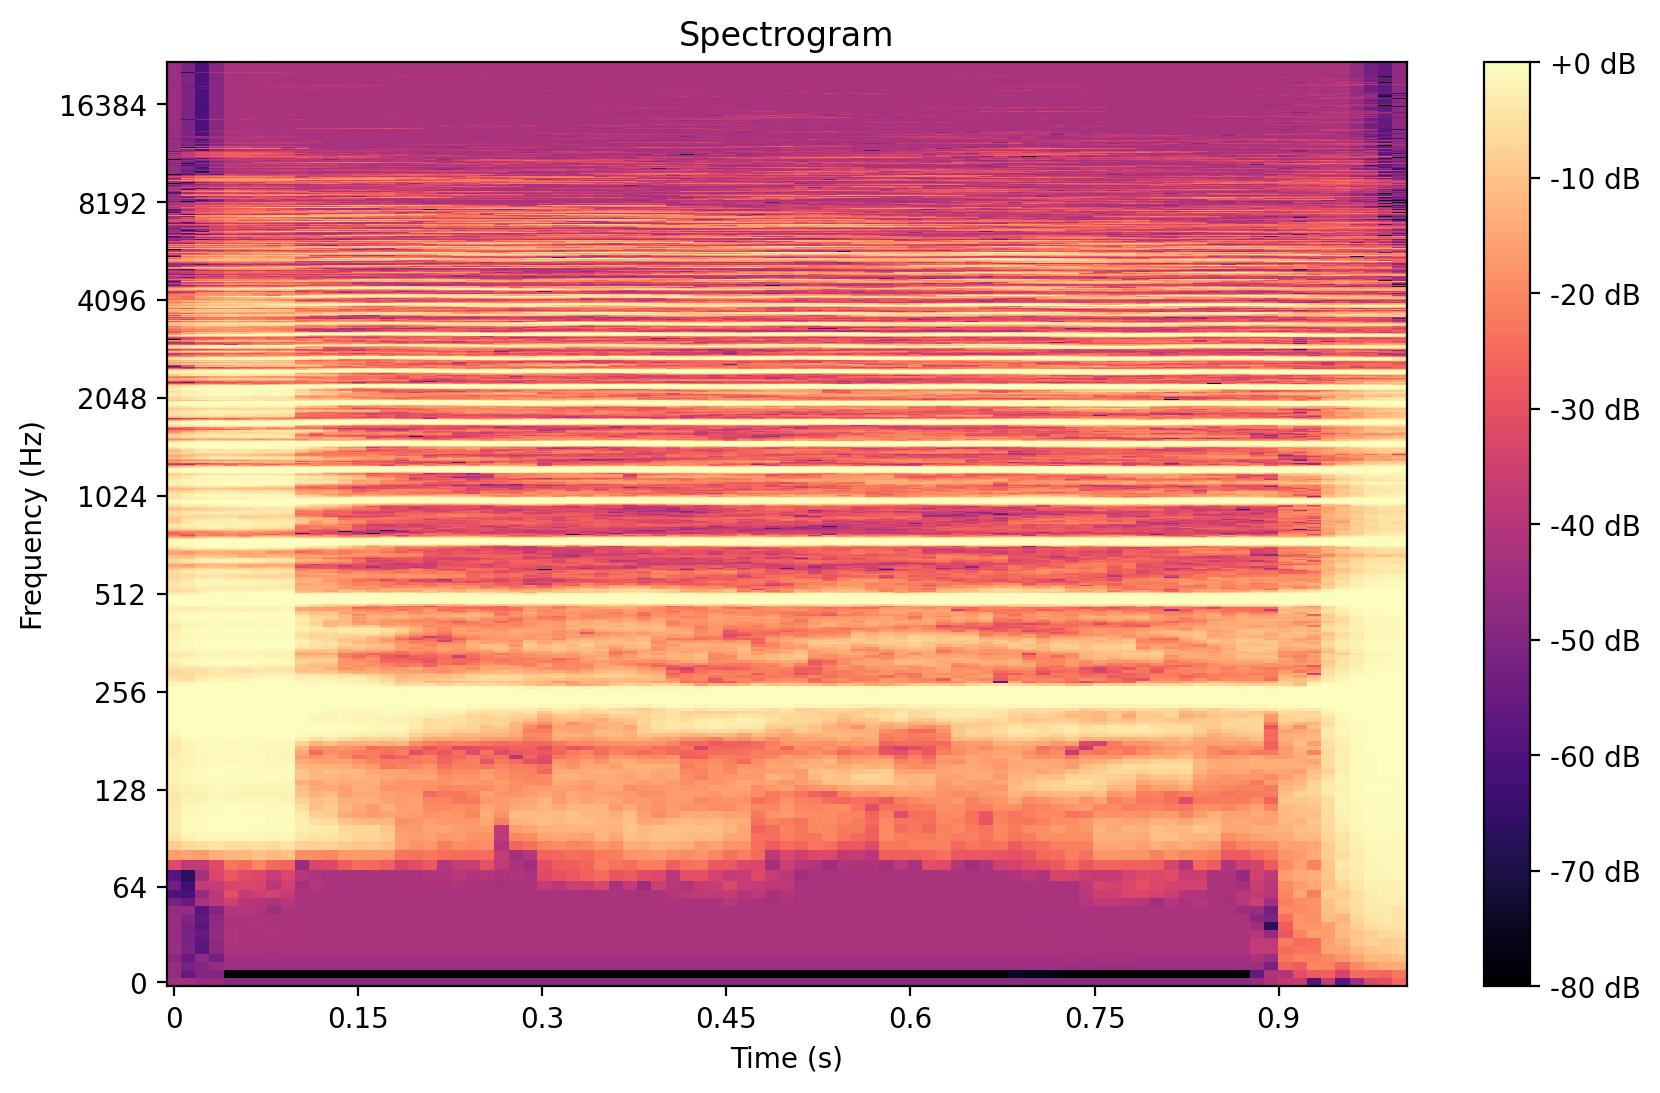

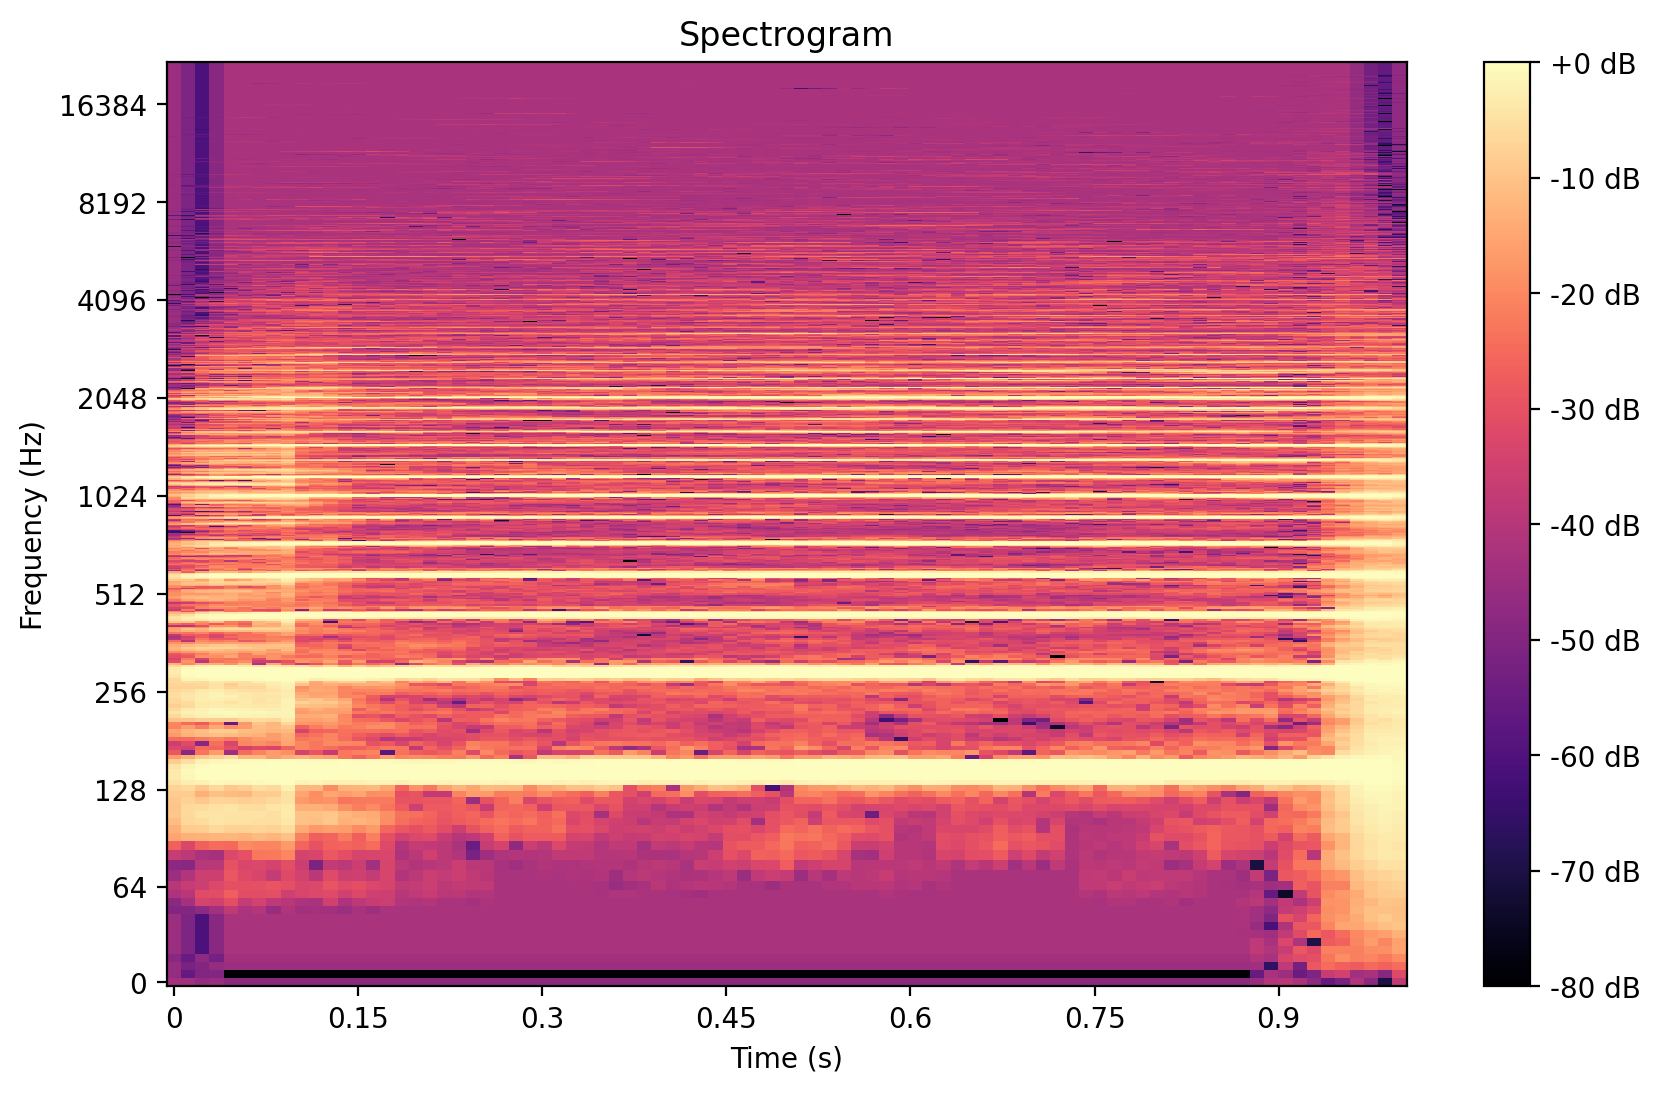

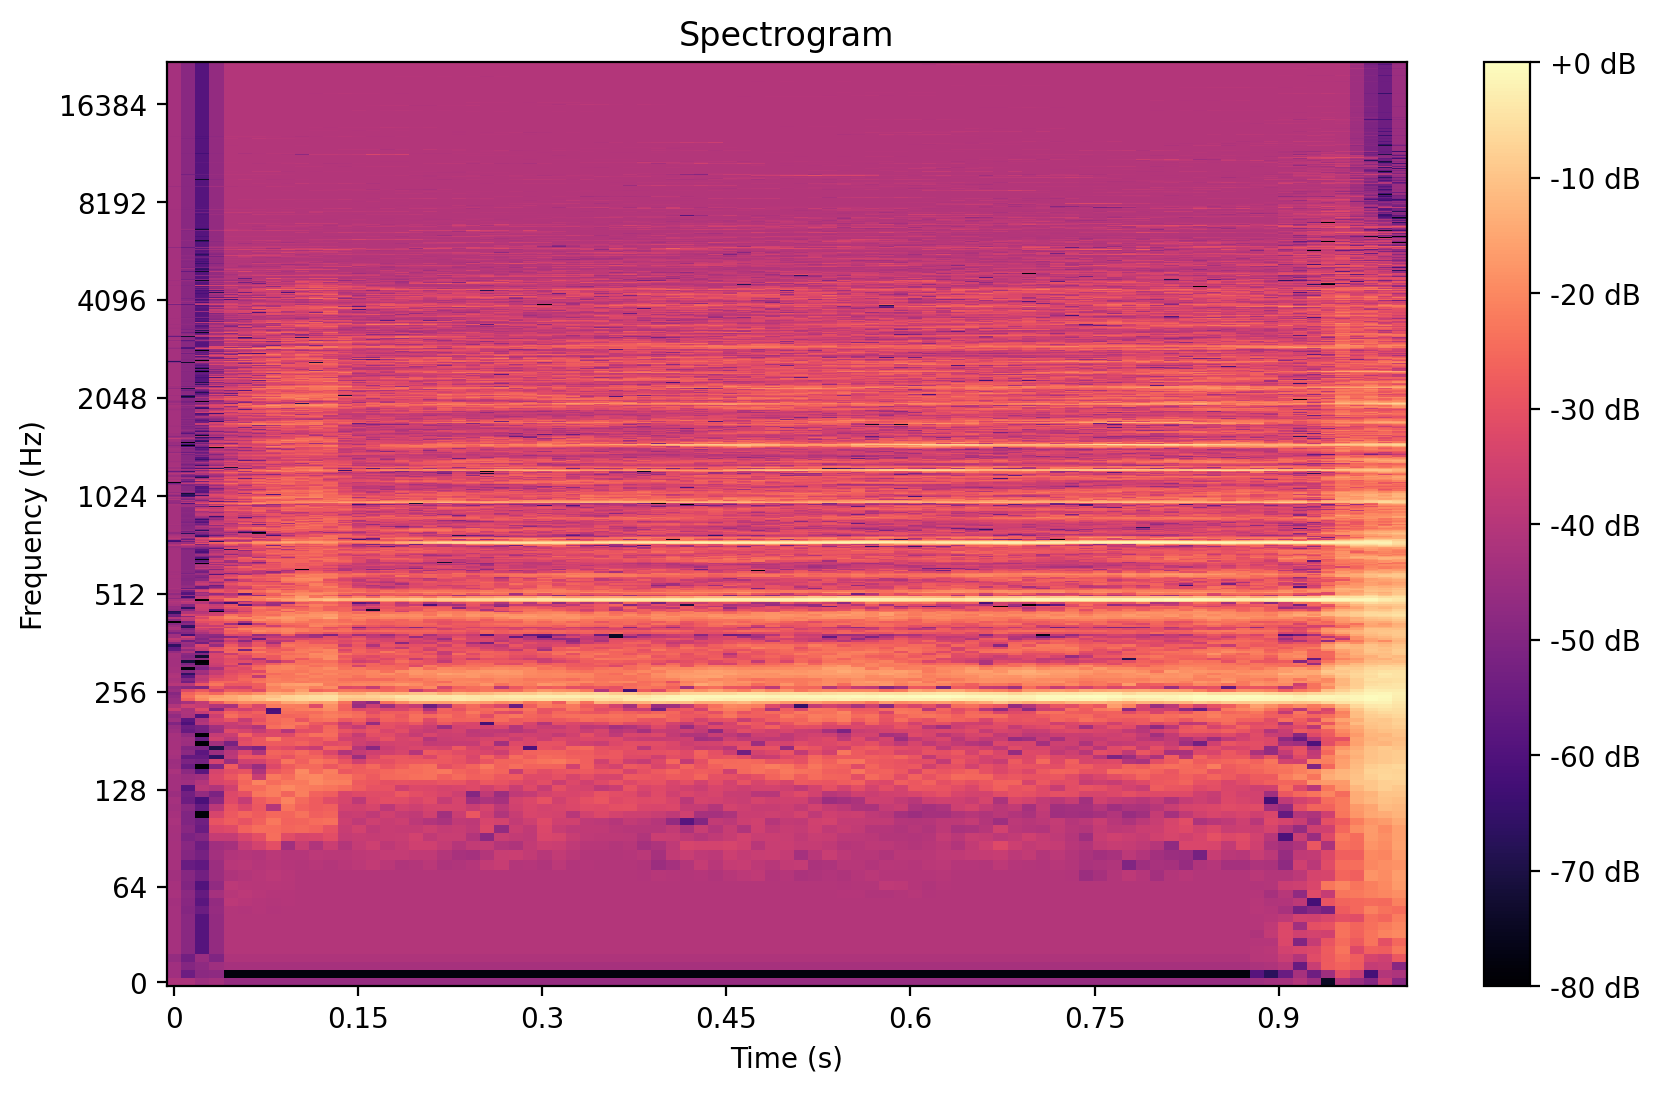

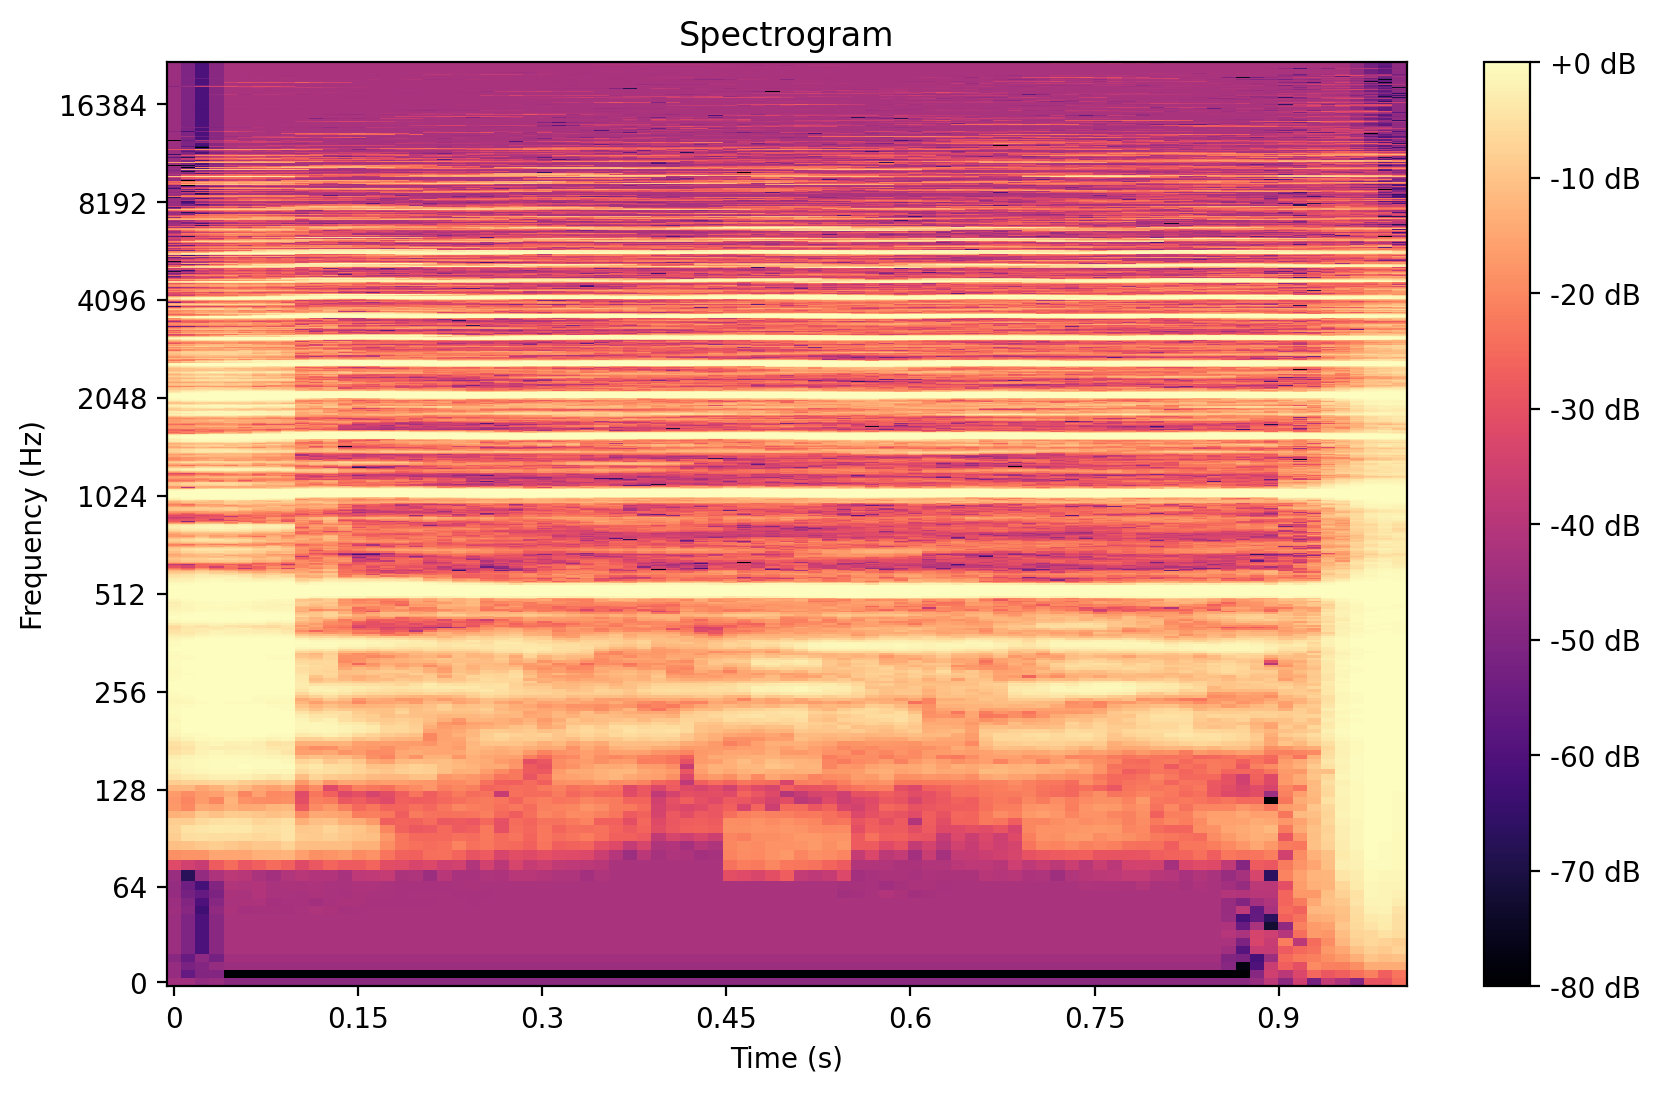

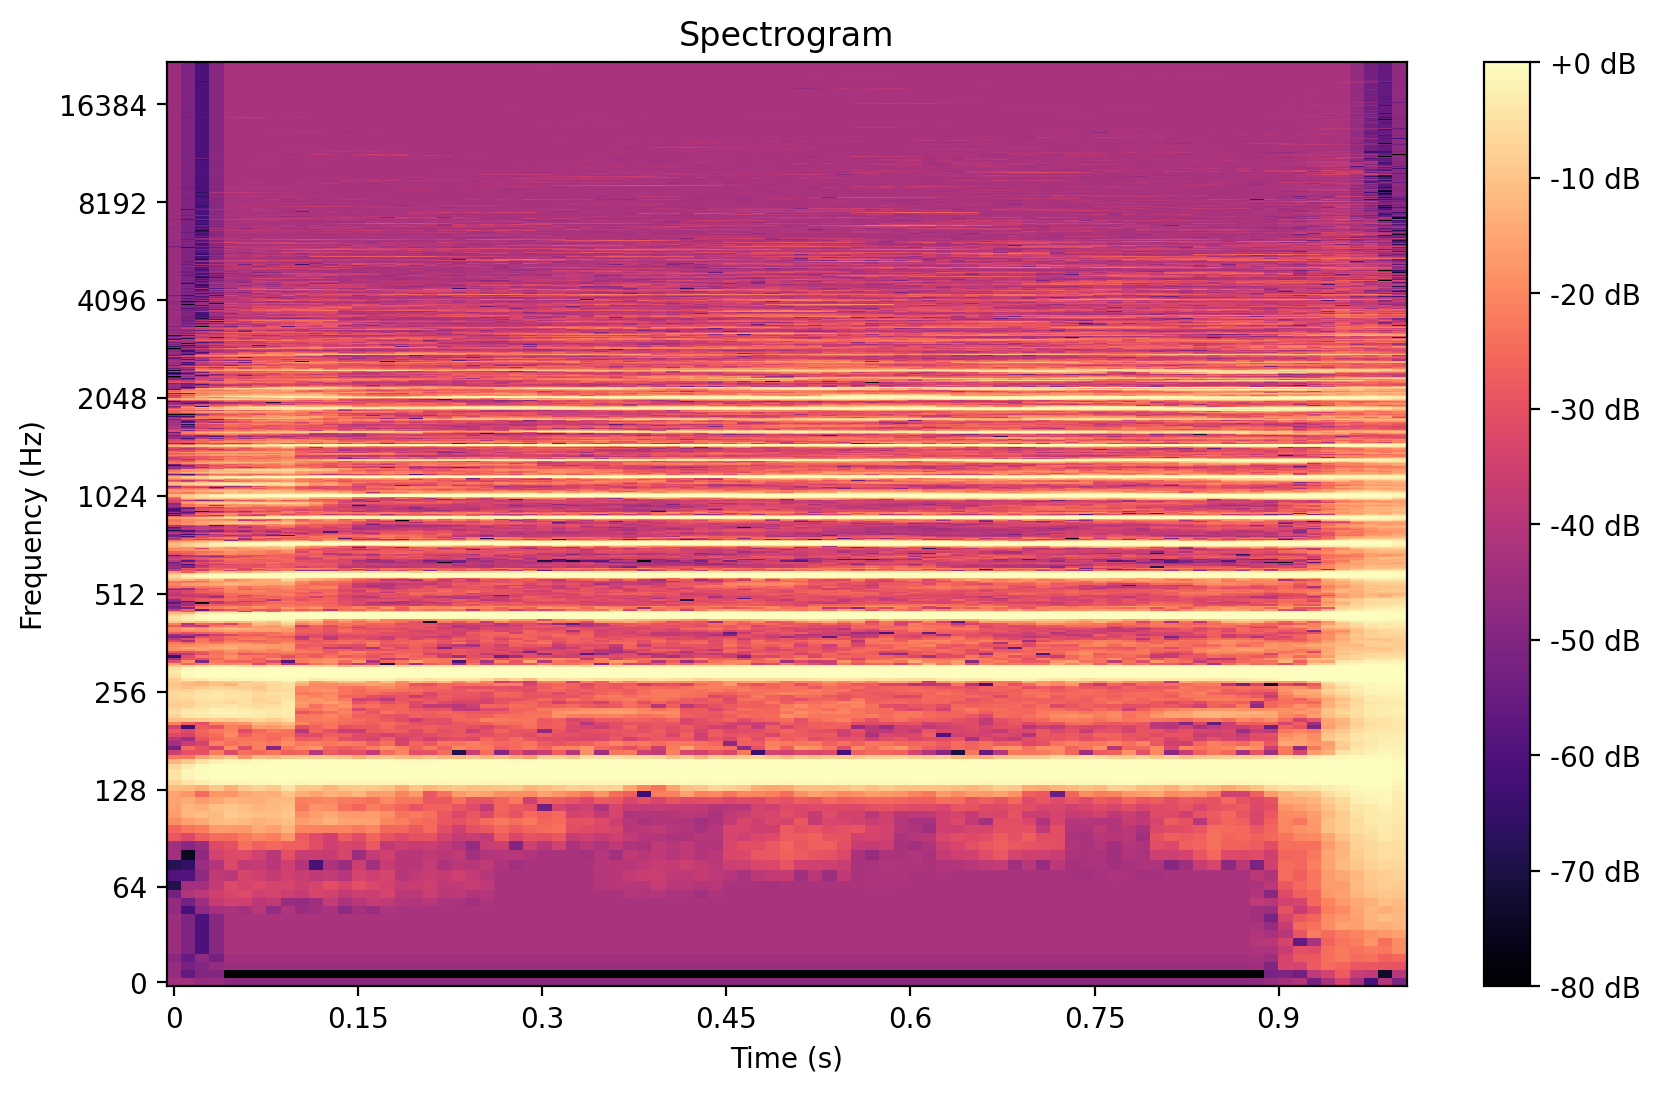

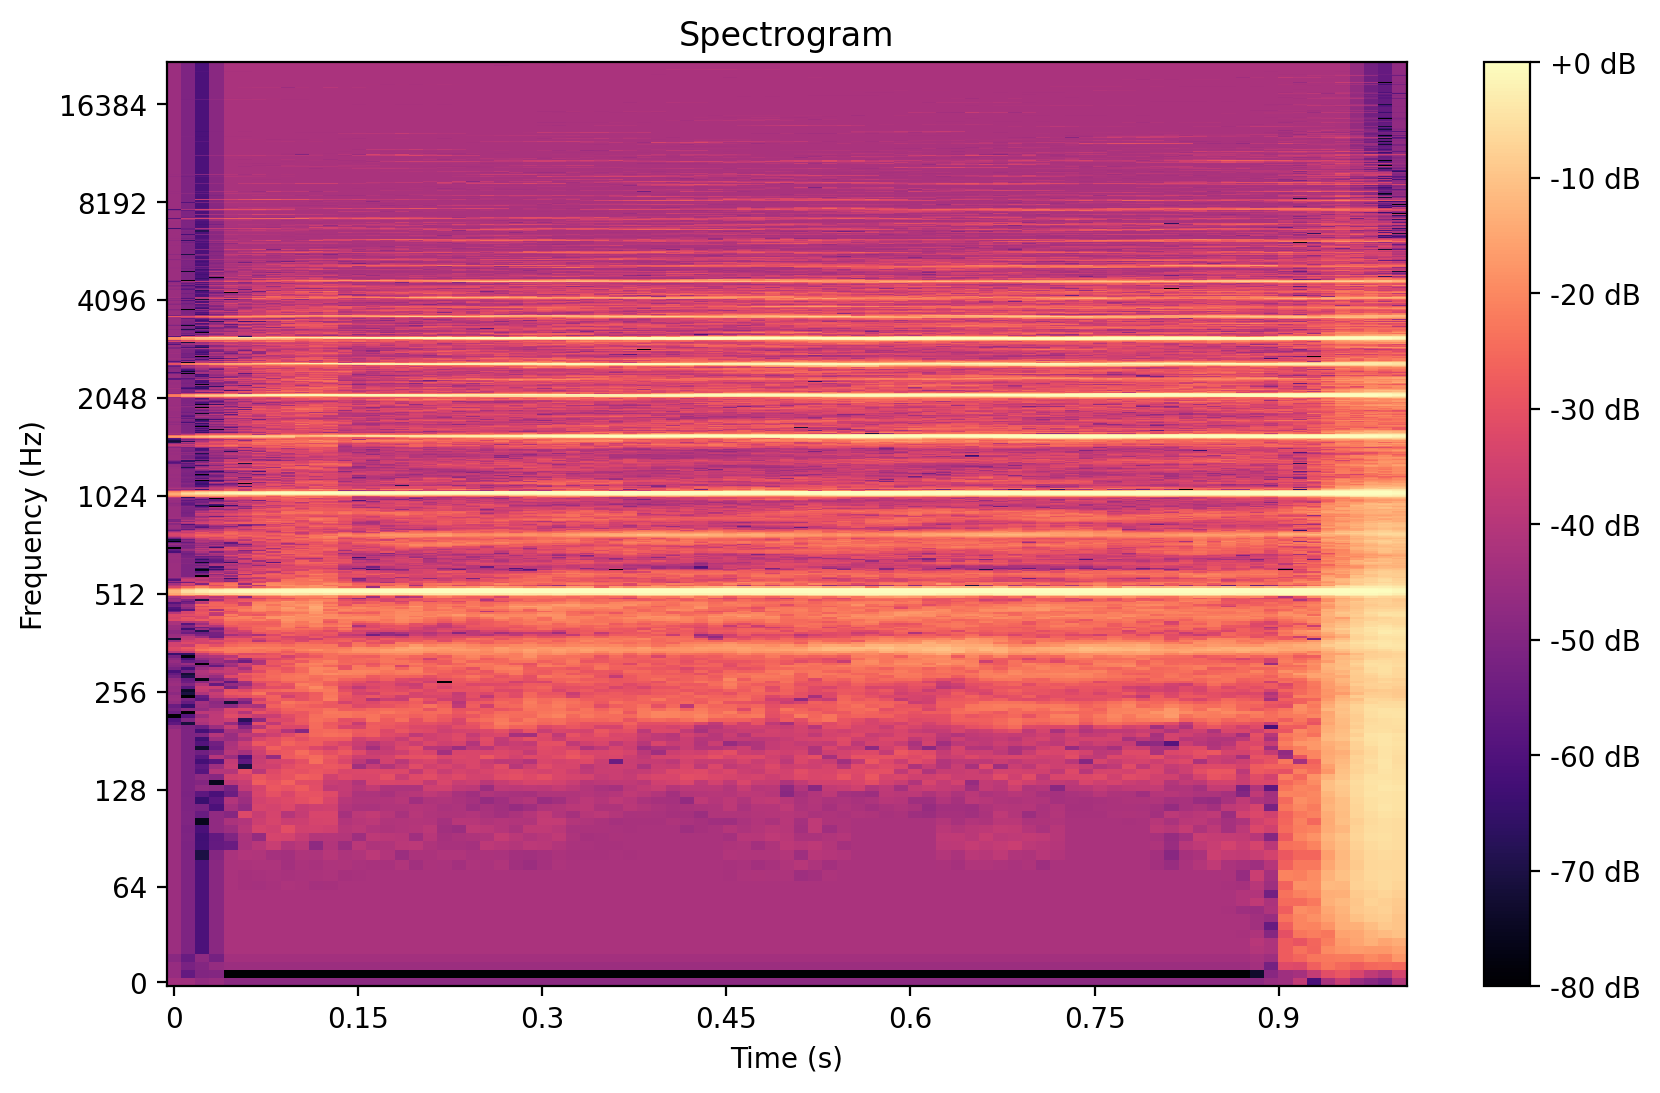

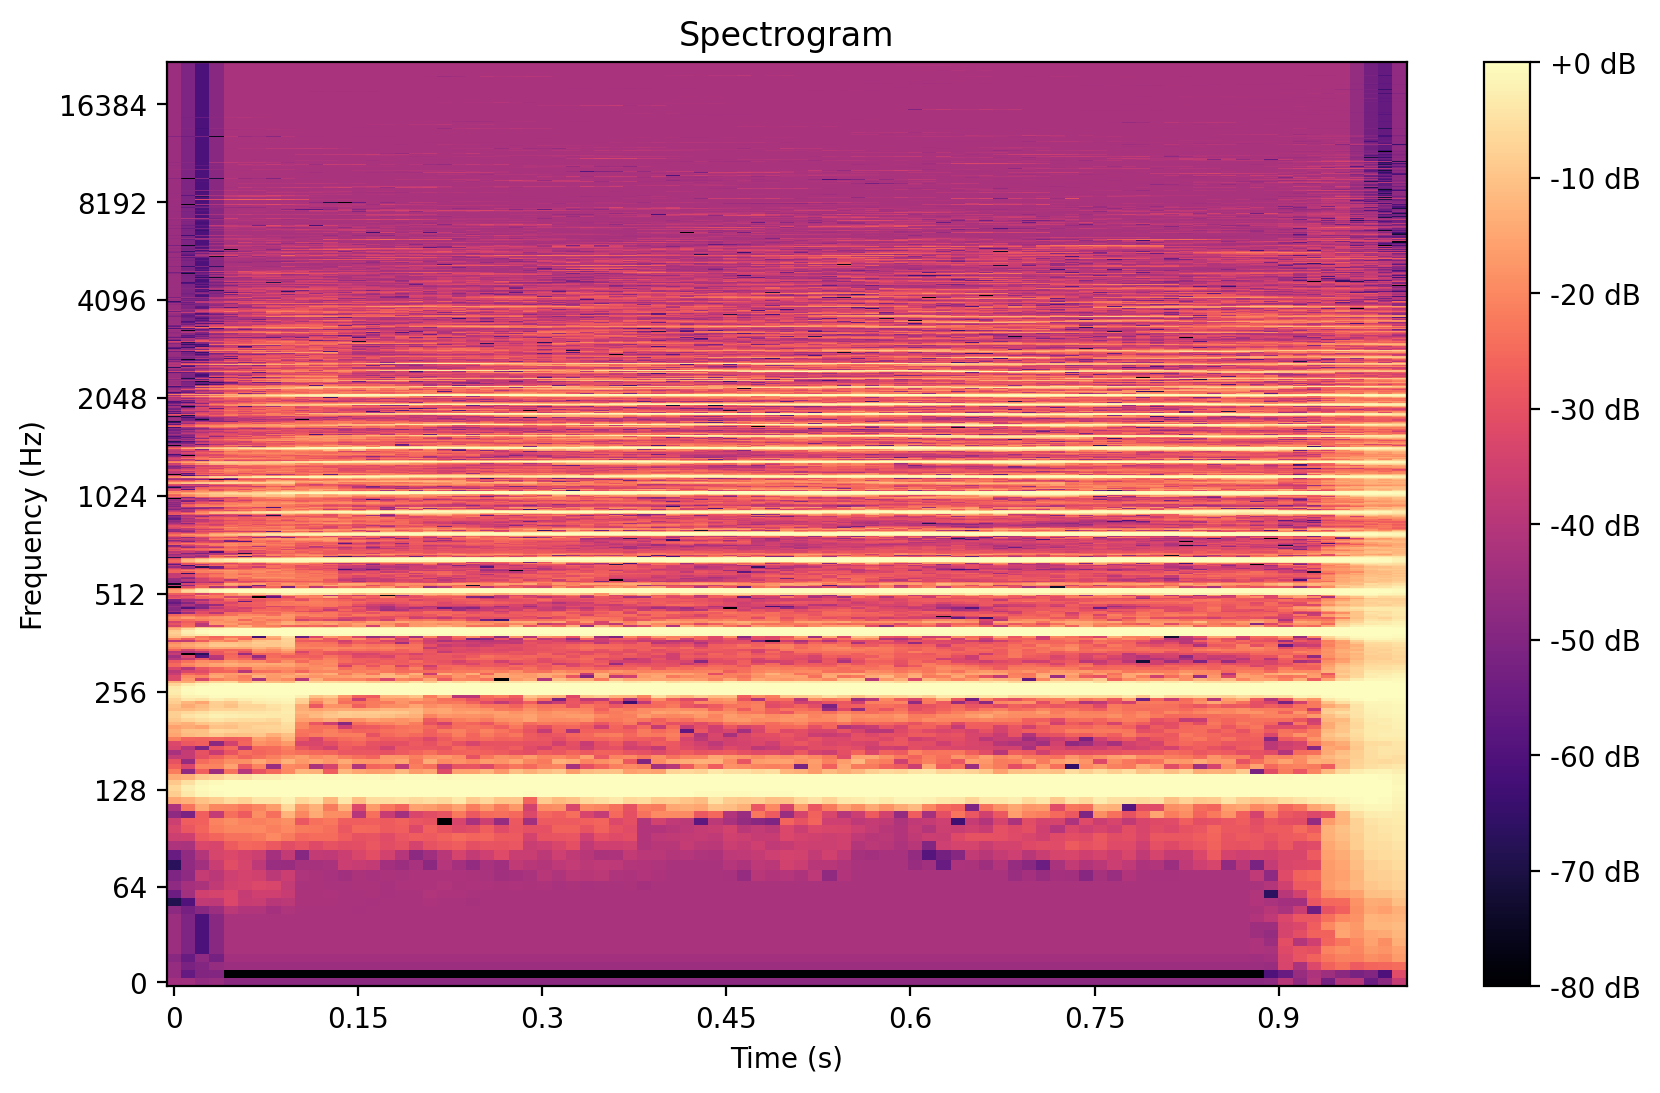

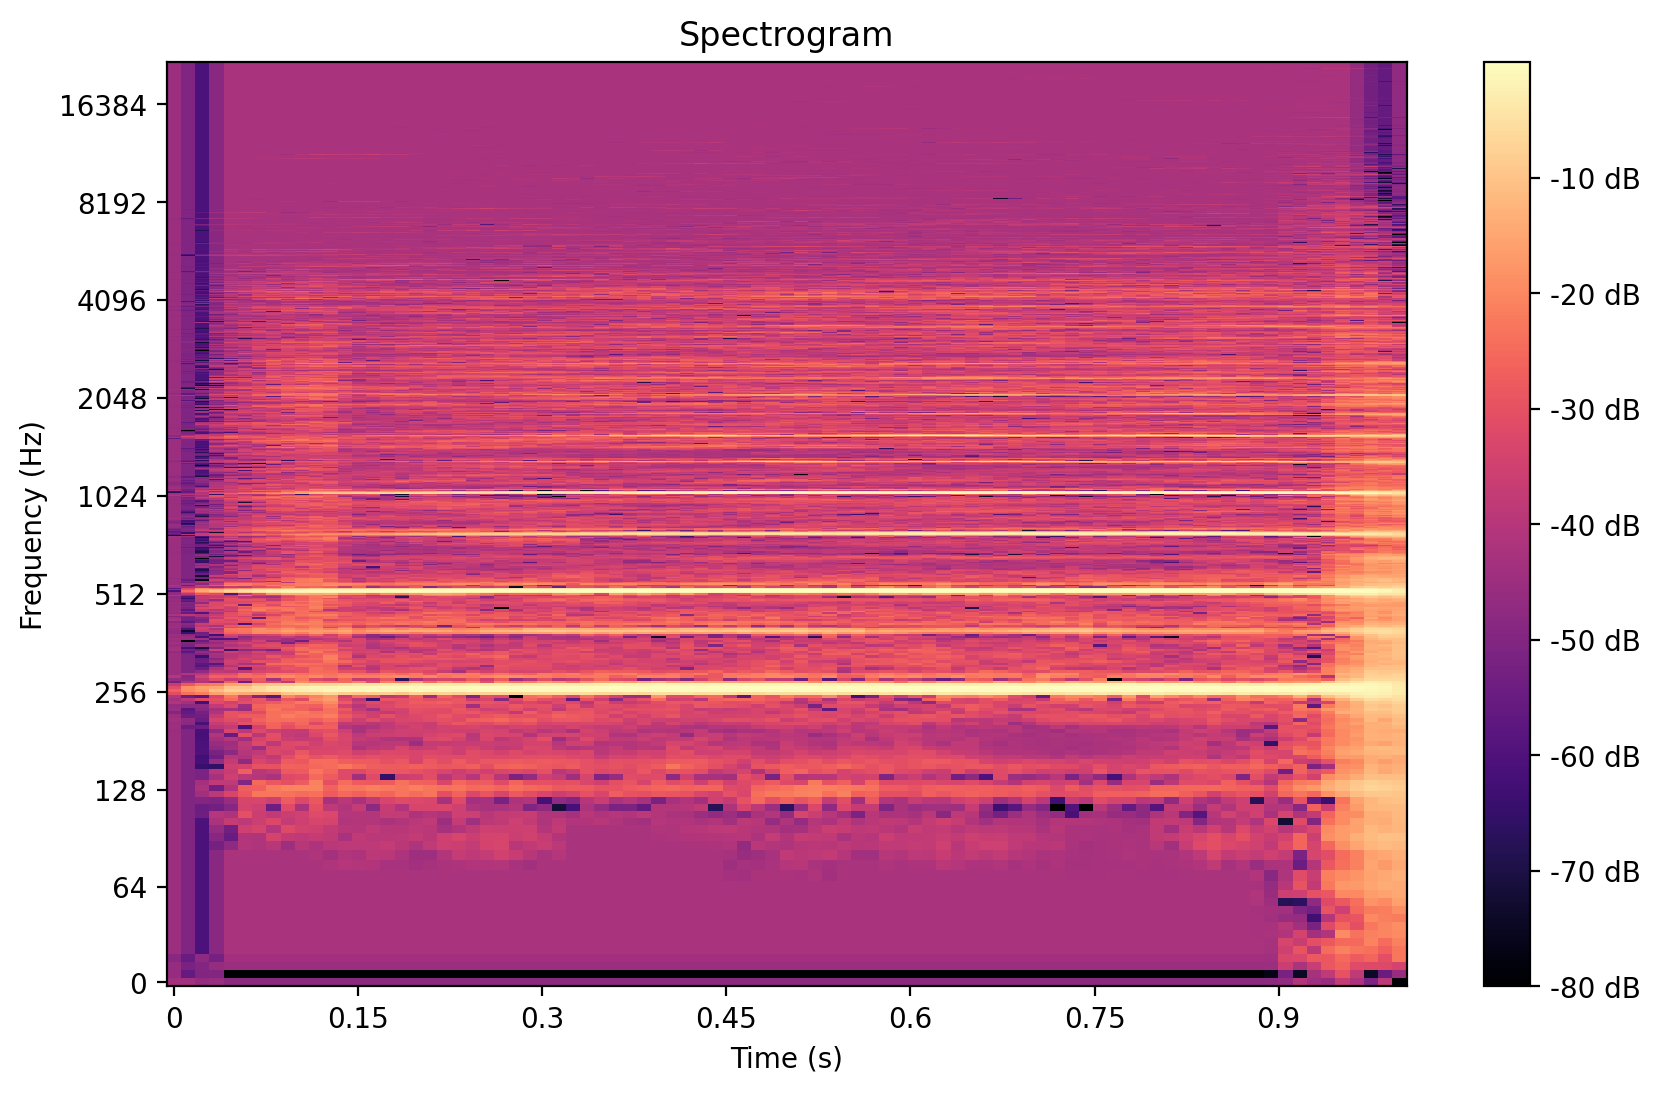

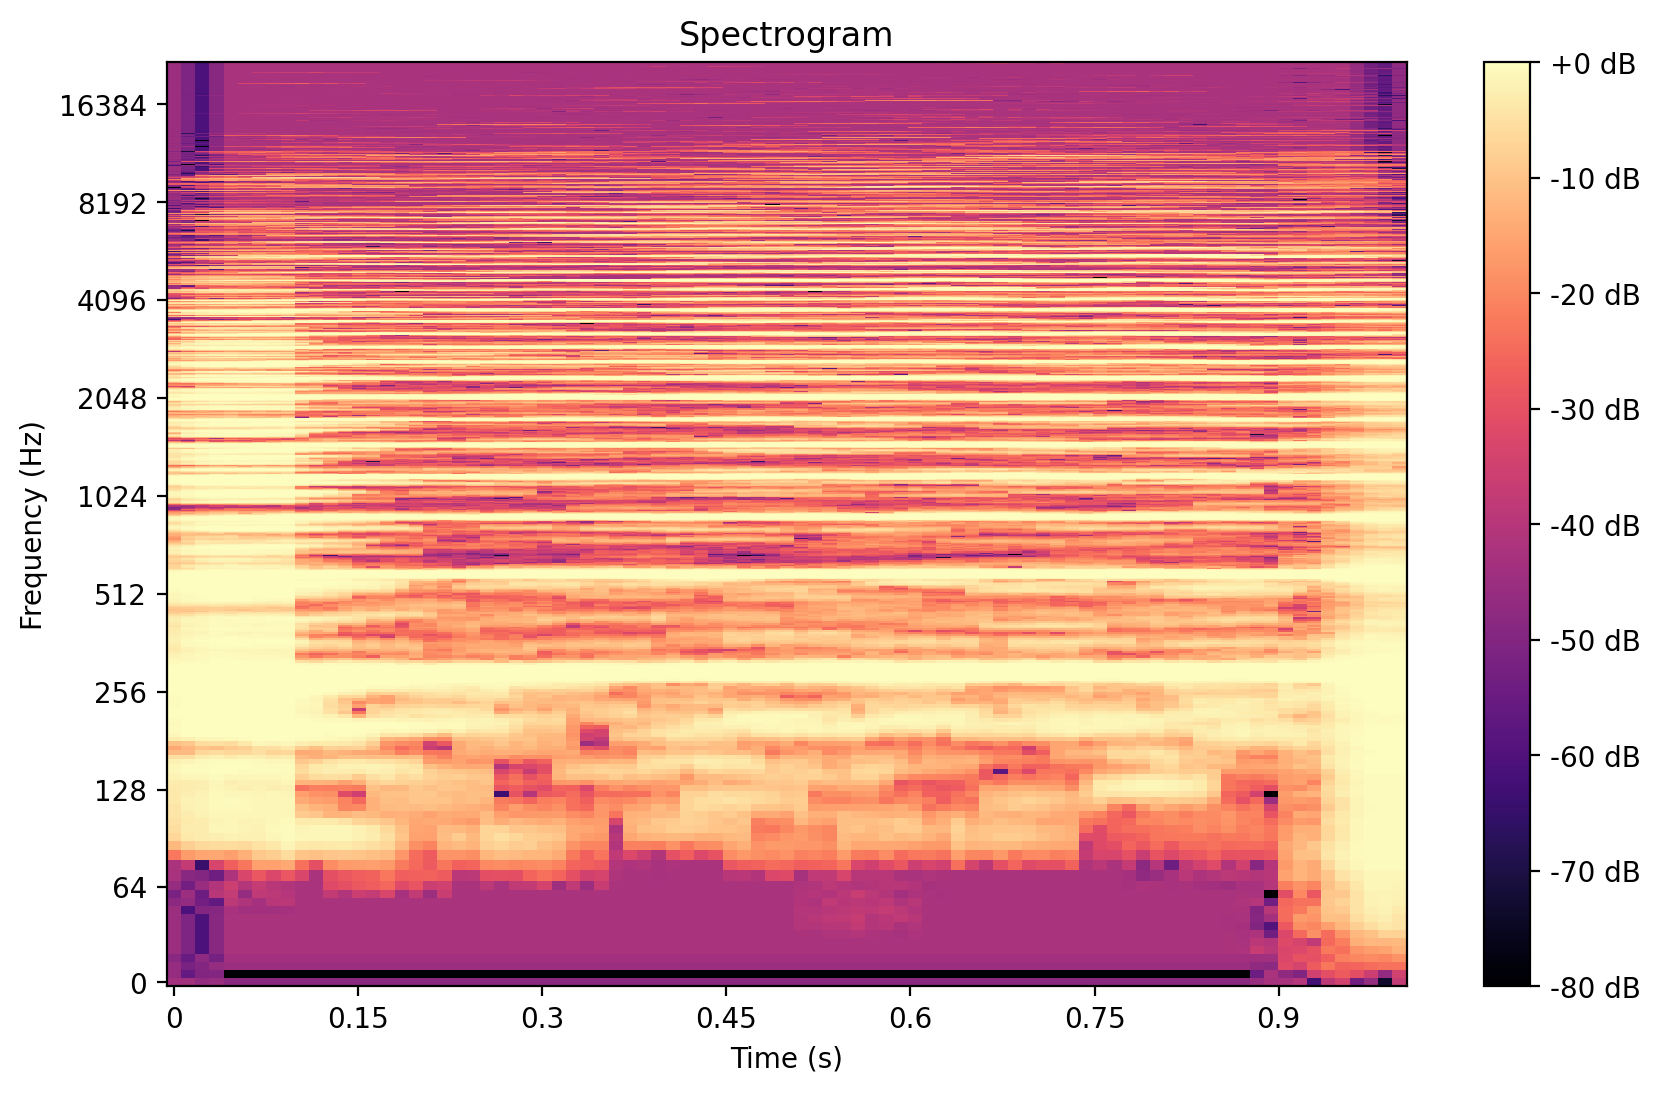

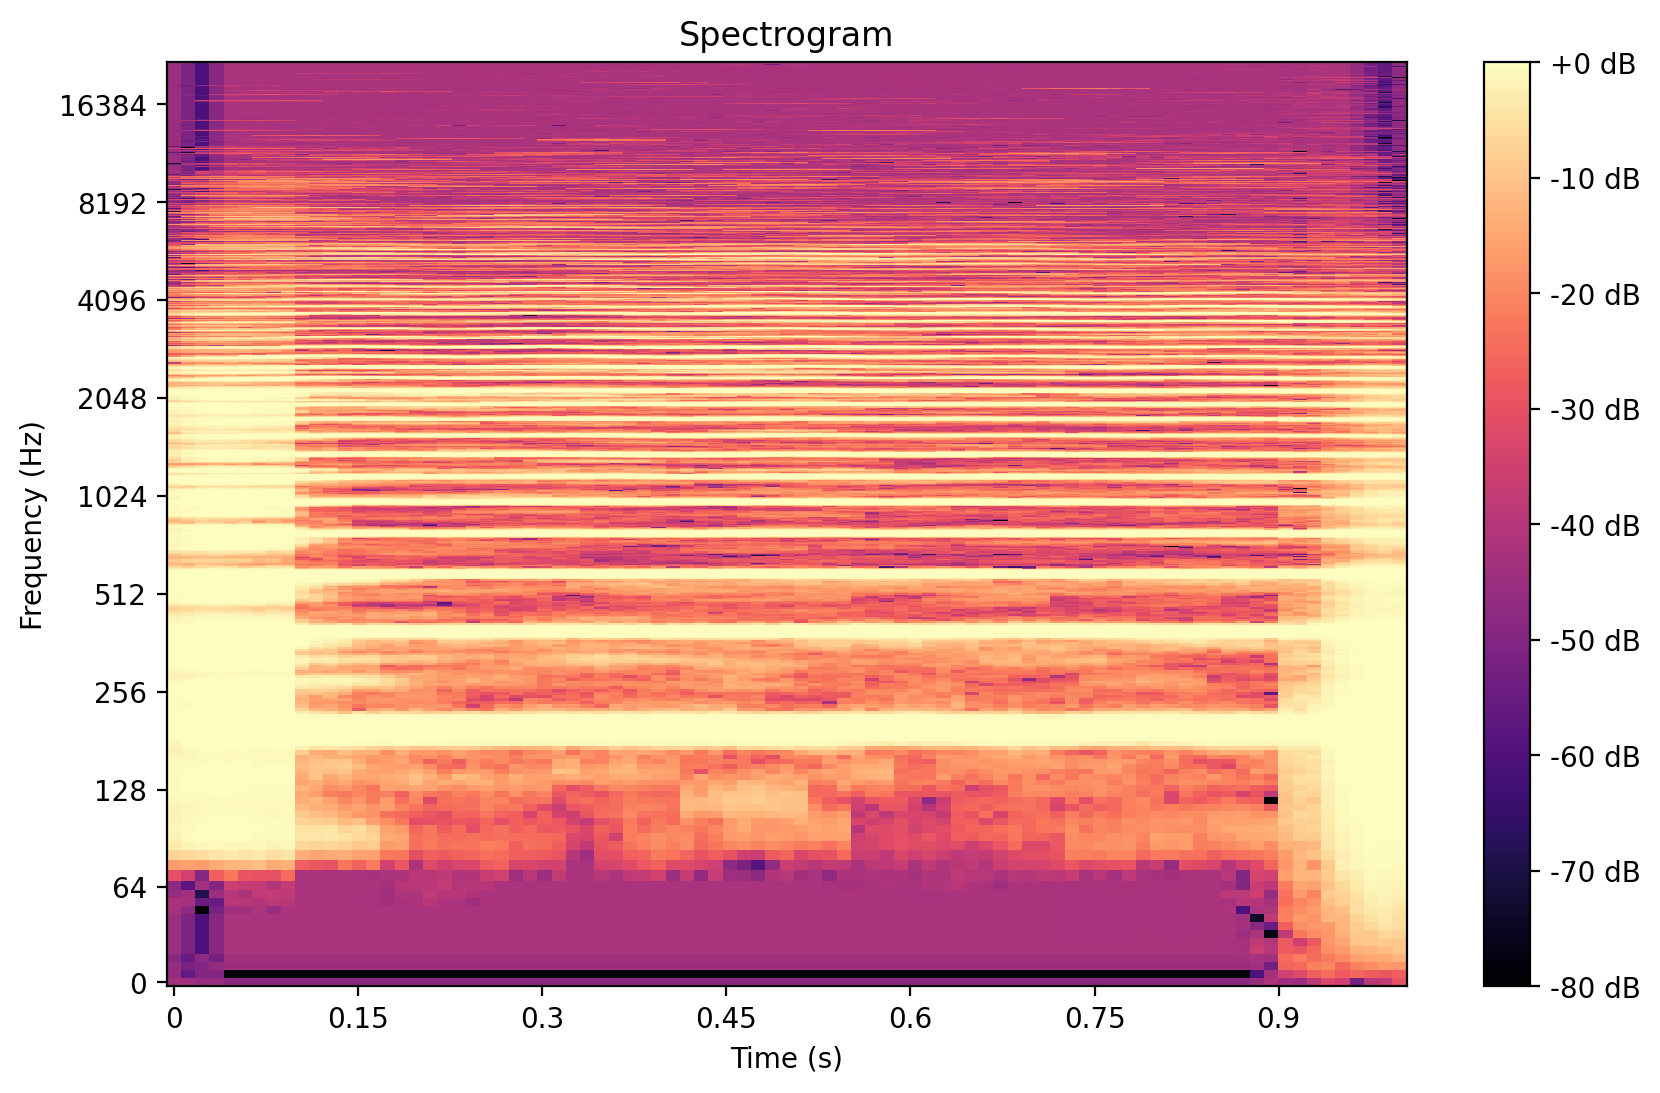

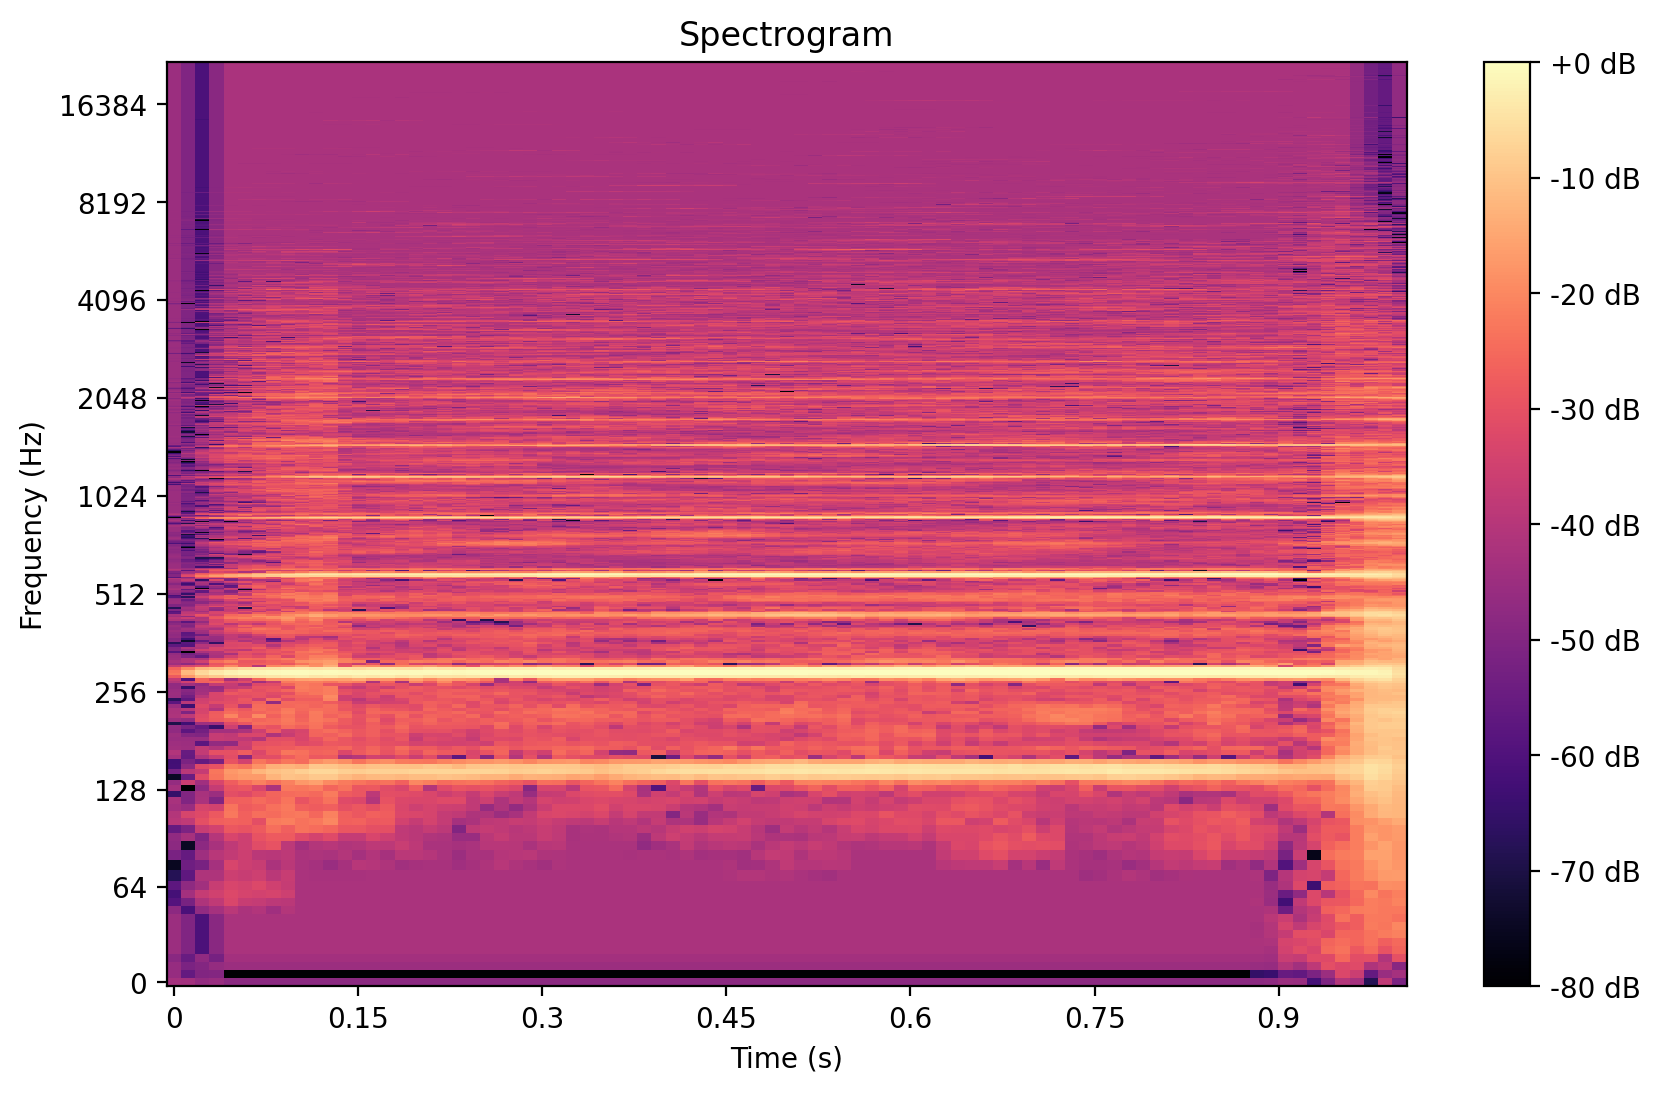

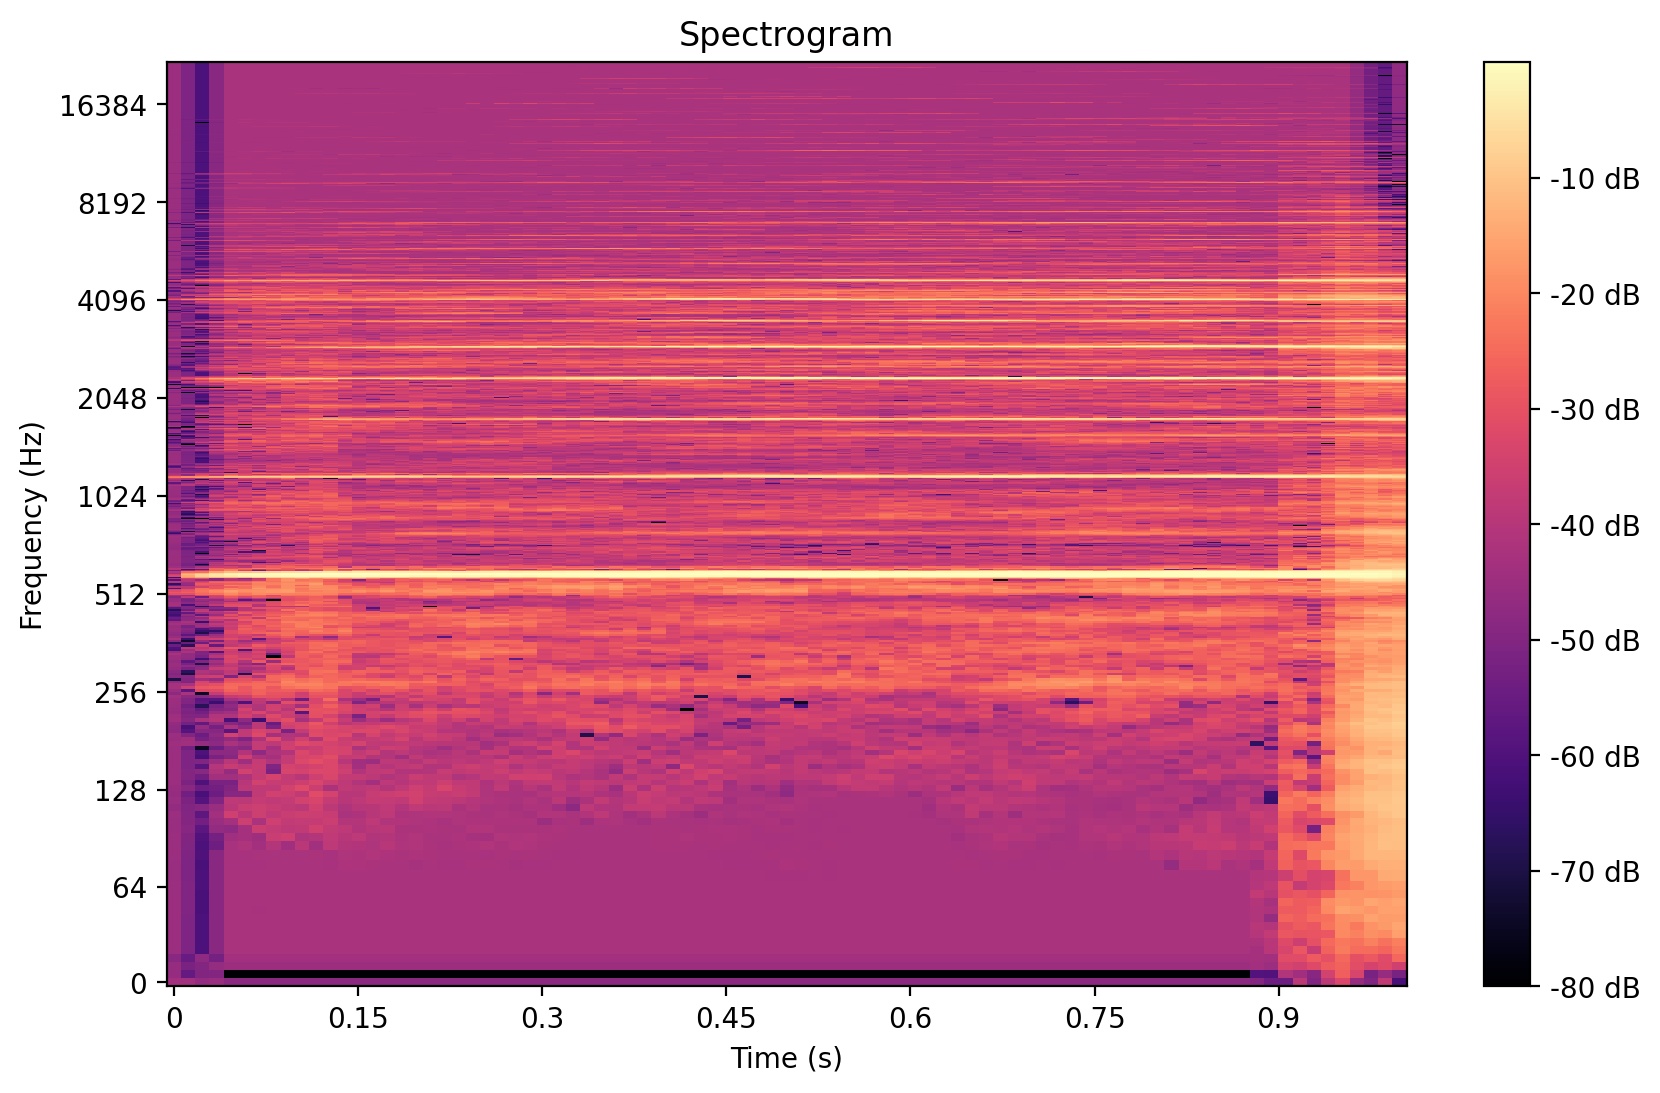

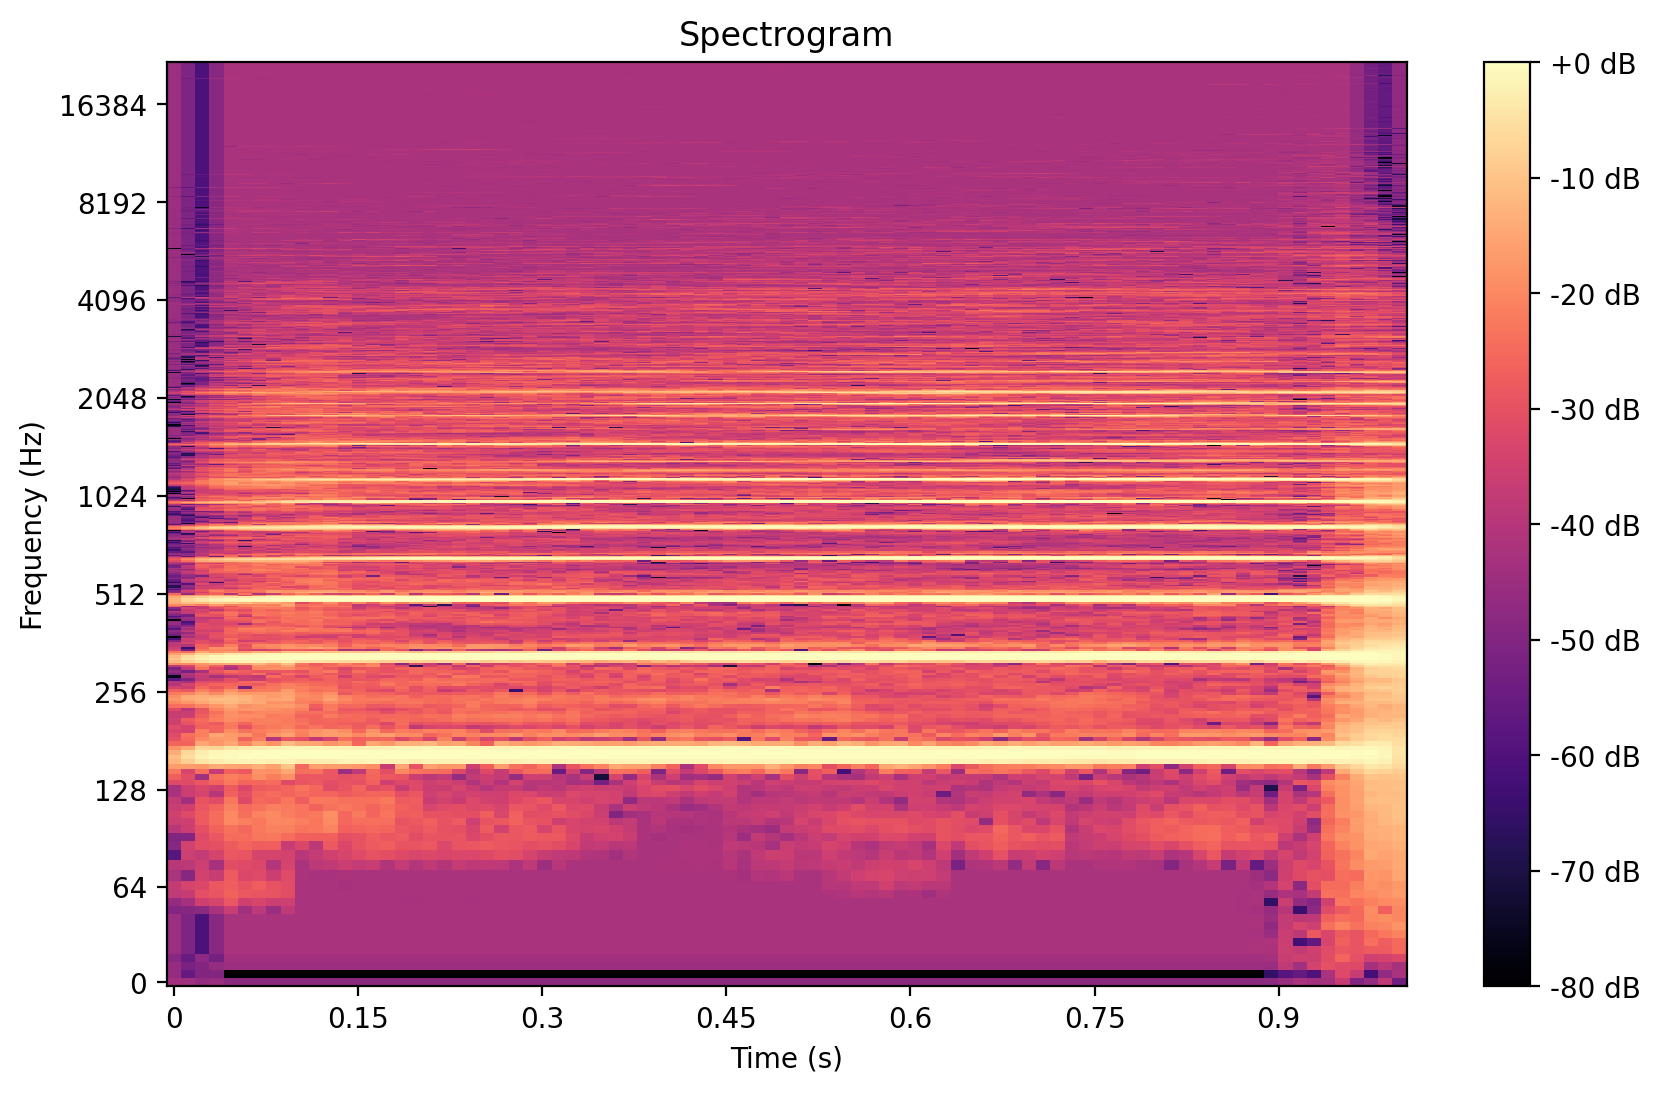

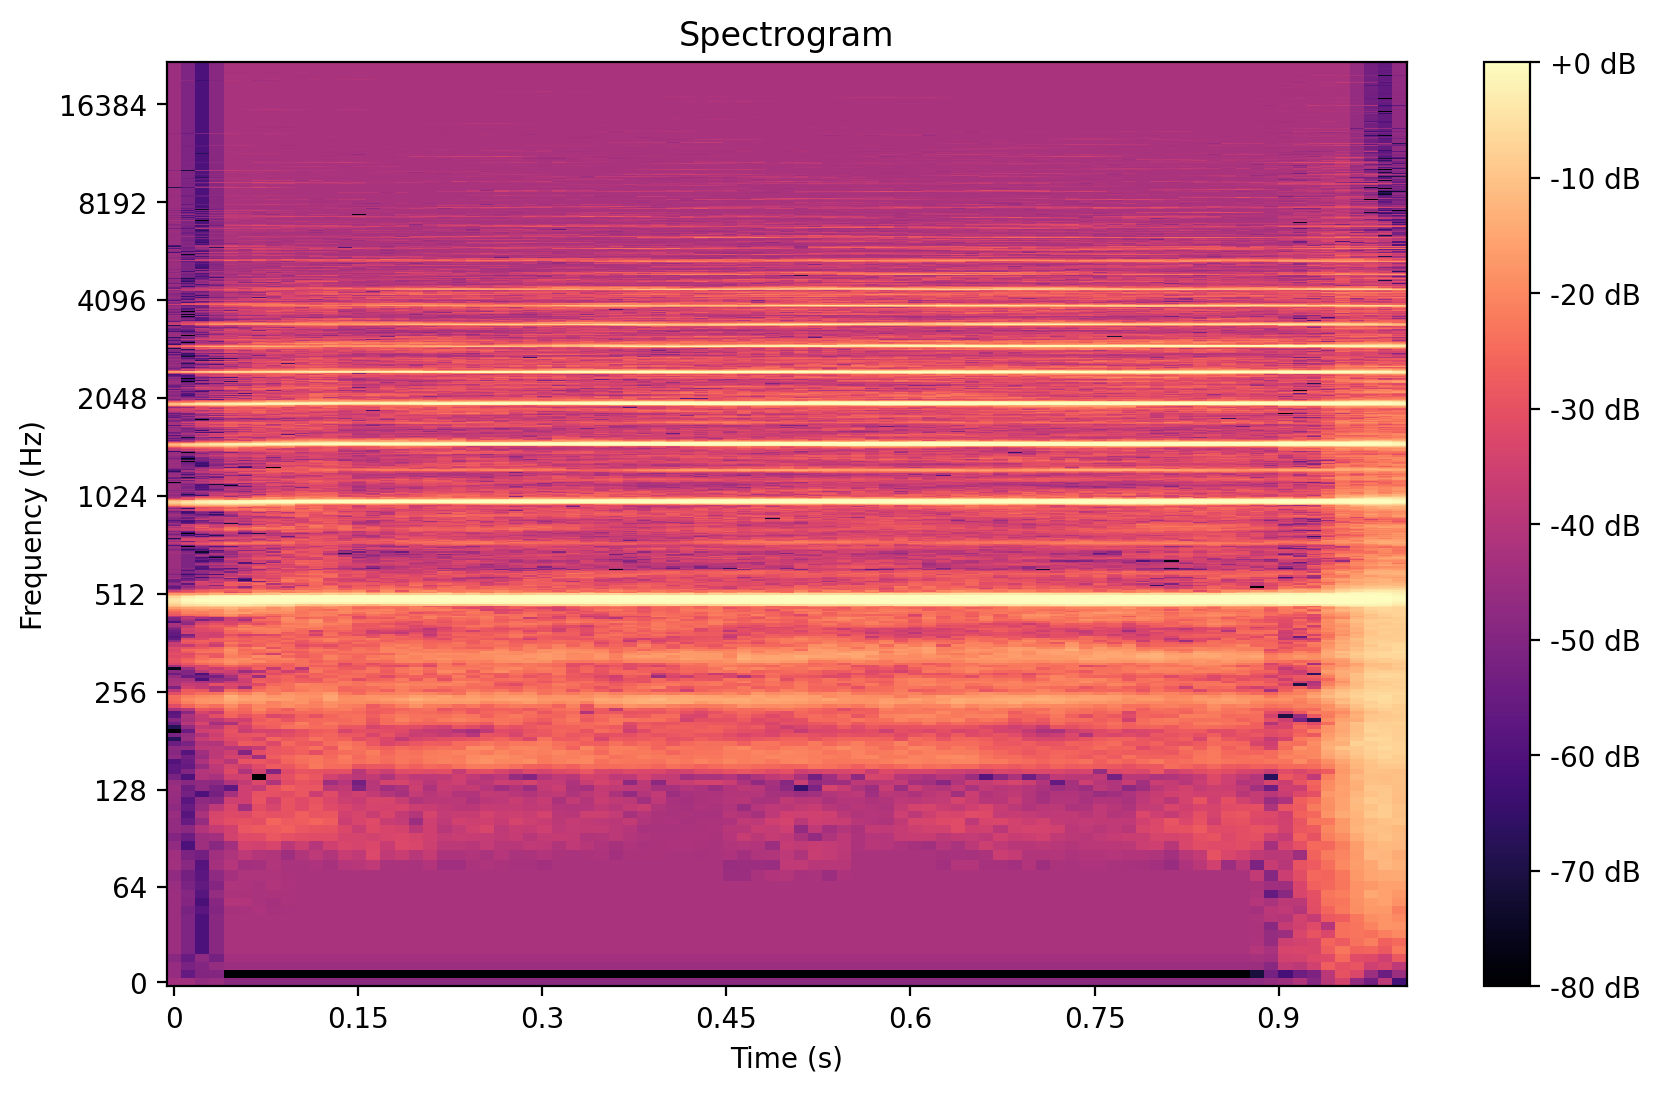

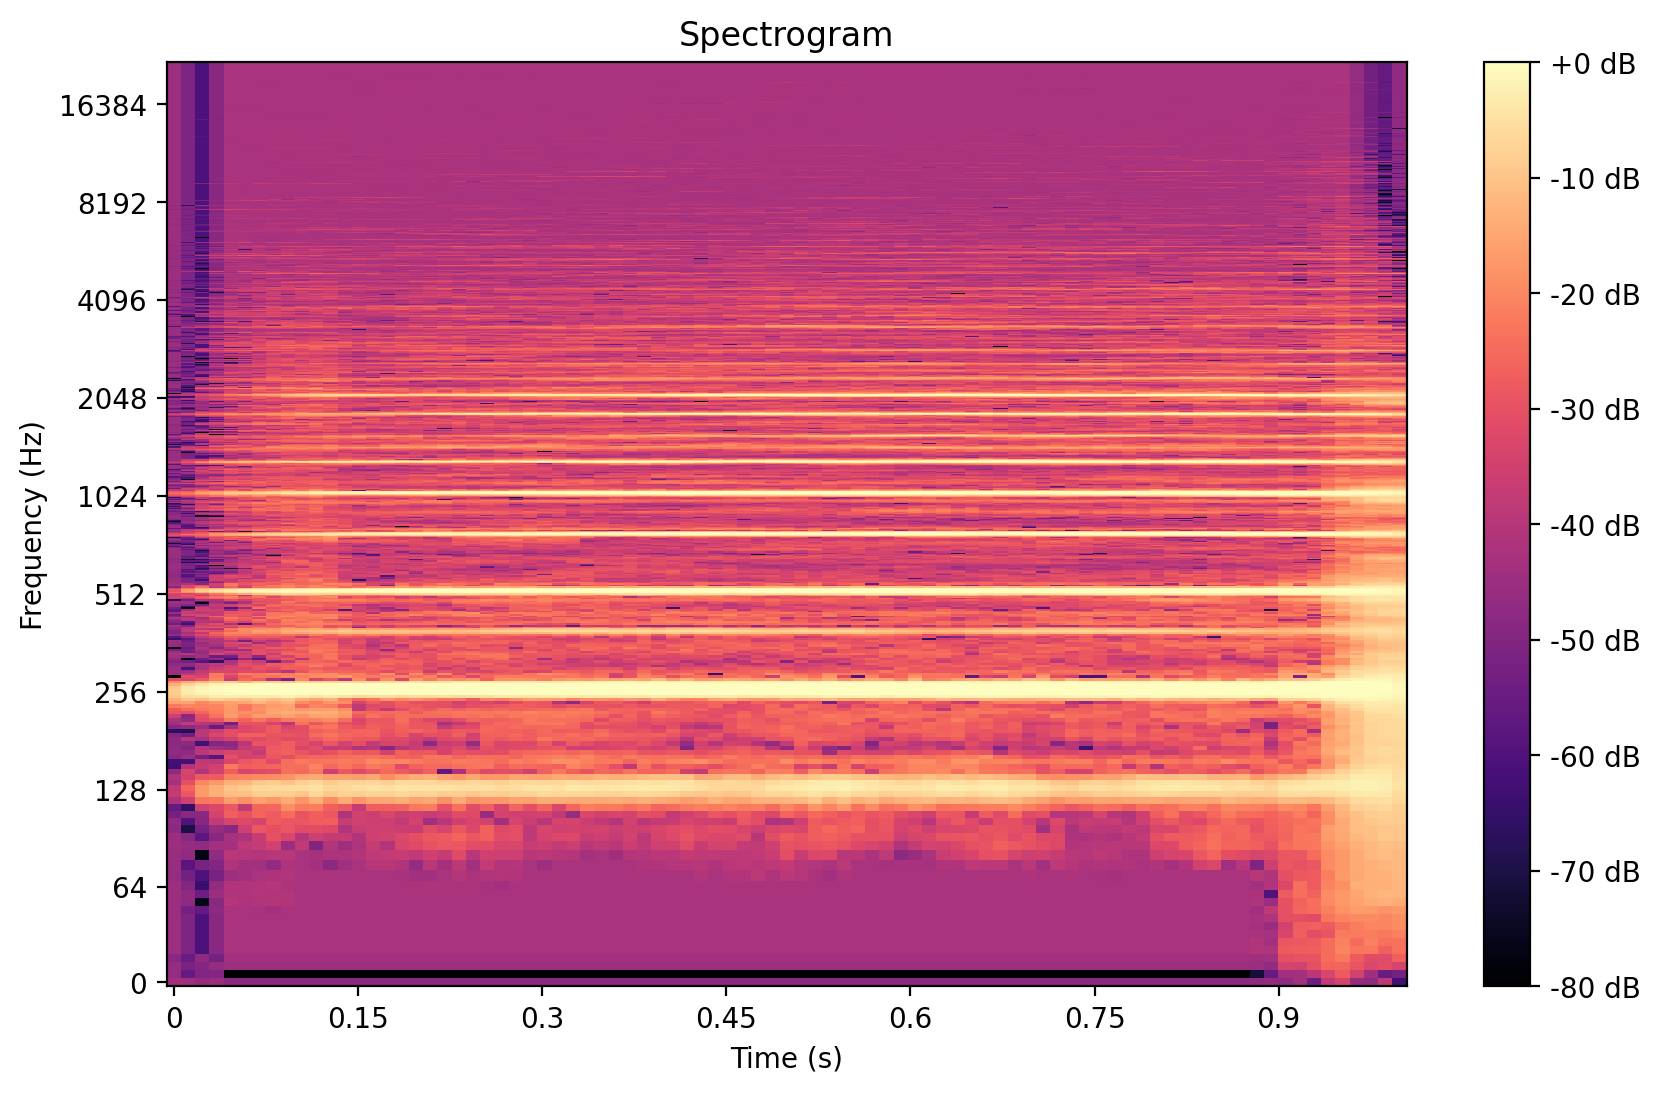

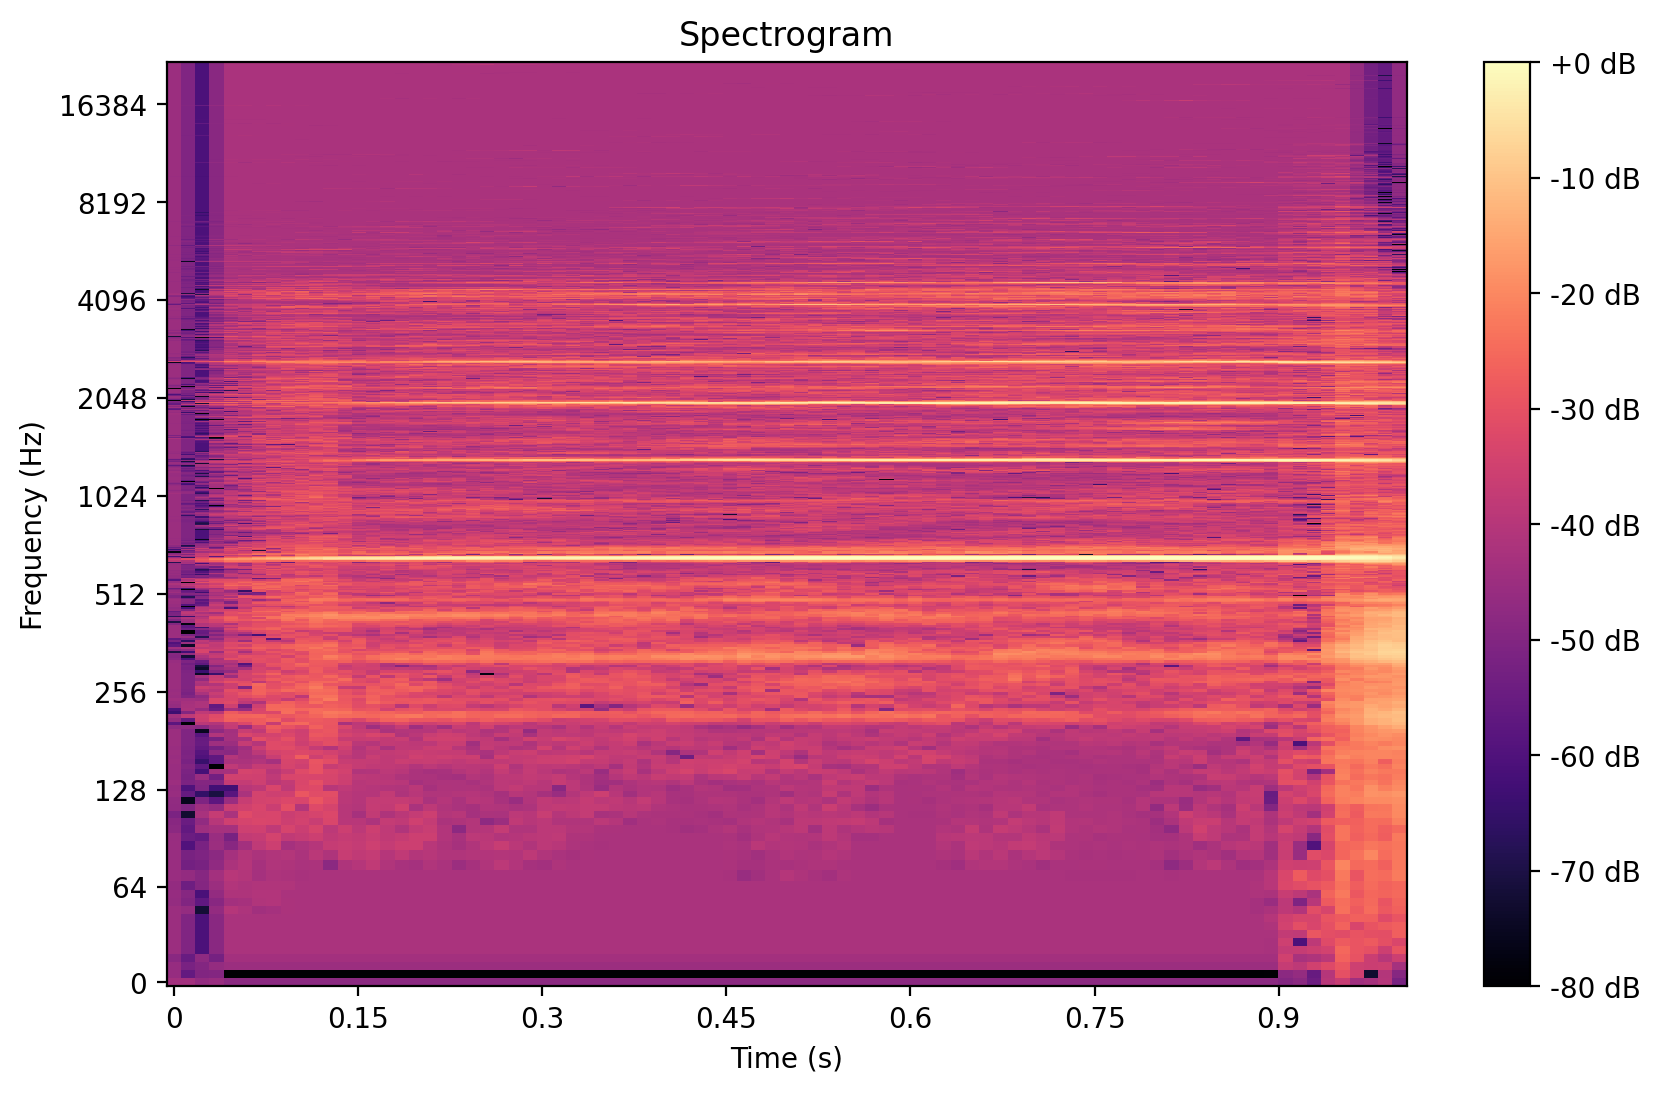

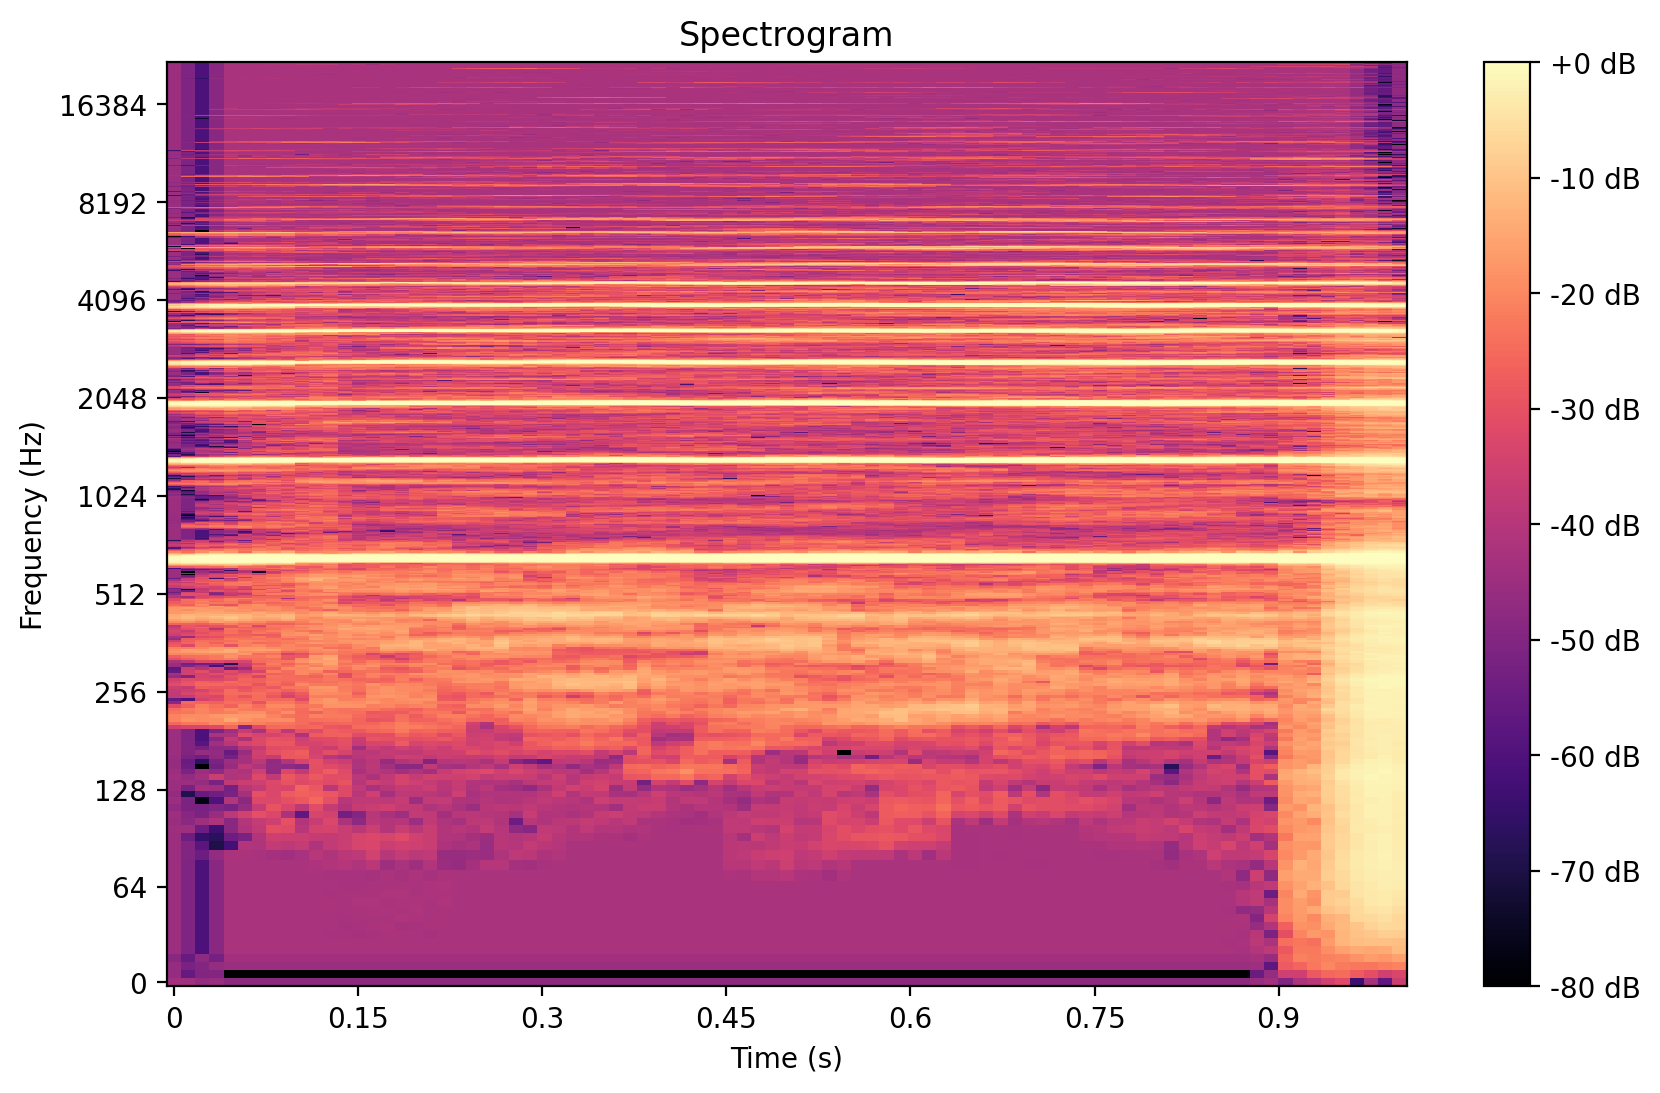

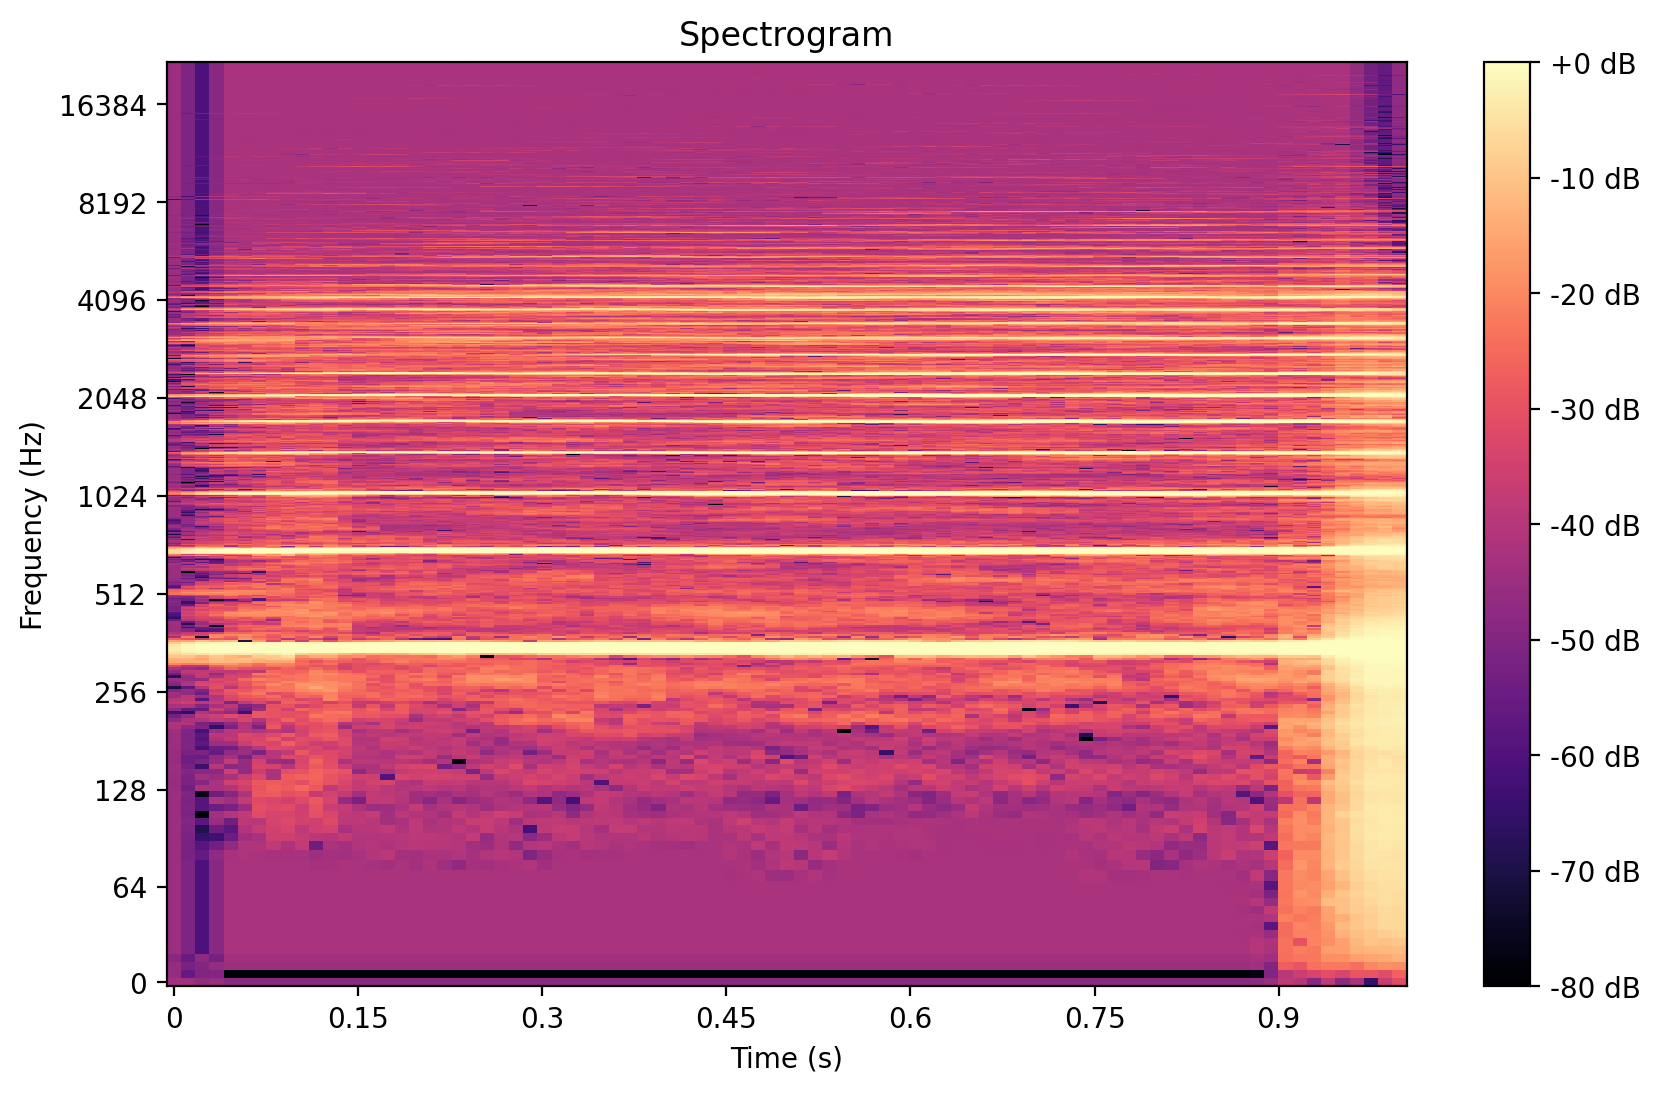

KeyboardInterrupt: 

In [17]:
for epoch in range(1, epochs + 1):
    test(epoch)

In [ ]:
#model_scripted = torch.jit.script(model) # Export to TorchScript
#model_scripted.save('VAE_violin_epc100_L1loss.pt') # Save

#VAE doesn't work
#VAE_org works

In [ ]:
#model = torch.jit.load('VAE_org.pt')
#model.eval()

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from tqdm import tqdm

In [29]:
device

device(type='mps')

100%|█████████▉| 363/364 [00:13<00:00, 27.24it/s]


<Axes: xlabel='x', ylabel='y'>

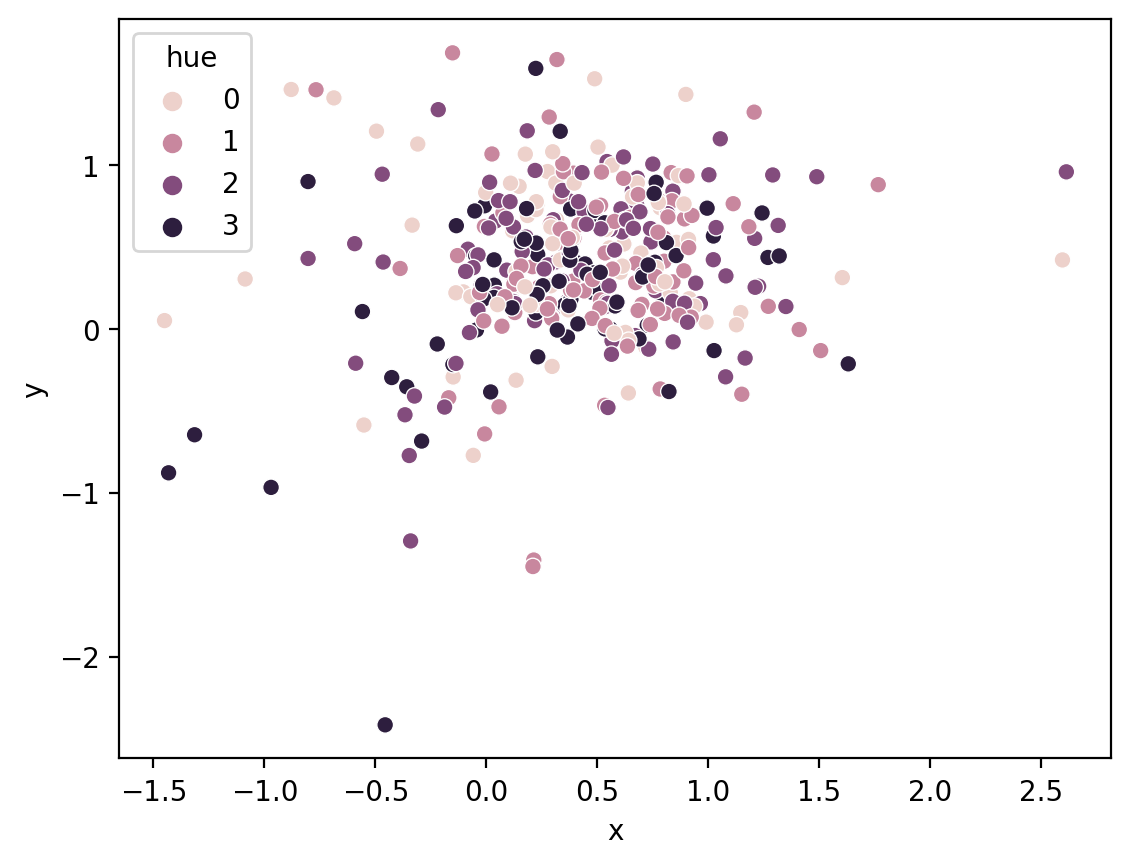

In [40]:
# plot the latent space

data = []
data_mu = []
data_logvar = []
targets = []

n_samples = int(len(train_ds))
counter = 0

#for batch_x, batch_y in tqdm(trainloader):
for batch_x, batch_y in tqdm(train_dl):
  float32_tensor = batch_x.to(dtype=torch.float32)
  batch_x = float32_tensor.to(device)
            
  #batch_x = data.cuda().float()
  
  mu, logvar = model.encode(batch_x)
  z = model.reparam_(mu, logvar).detach().cpu().numpy()

  
  for x, y in zip(z, batch_y):
    data.append(x)
    targets.append(y)
    counter += 1

  if counter >= n_samples:
    break

data = np.array(data)
targets = np.array(targets)

df = pd.DataFrame({"x":data[:, 0], "y":data[:,1], "hue":targets})
sns.scatterplot(x="x", y="y", hue="hue", data=df, legend='full')

In [33]:
data

array([], dtype=float64)